# Notebook content structure
---
### Data
- Import csv's 
- Import libraries

### EDA
- Bar Plot
- Feature Engineering 
- Pivot Tables
- Outlier Detection

### Testing forecasting models for a single combination Freight Forwarder - Factory
- SARIMA
- Exponential Smoothing
- Recurrent Neural Networks 
- Model Evaluation: Mean Absolute Percentage Error (MAPE)

### Forecasting each Freight Forwarder - Factory combination
- Iterate over combinations, plot results and store output

In [1]:
# import libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import itertools
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import load_model
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
import warnings 
warnings.filterwarnings("ignore")
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose 

C:\Users\jonas\Anaconda3\envs\ML\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\jonas\Anaconda3\envs\ML\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\jonas\Anaconda3\envs\ML\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# import and store csv files in dataframes
prod_df = pd.read_csv("Prod.csv", sep=";")
trans_df = pd.read_csv("Trans.csv", sep=";")

In [3]:
prod_df.head()

,Months,Plant 1,Plant 2,Plant 3
0,1,33839,45147,19438
1,2,36690,42656,24252
2,3,38211,46226,24978
3,4,36979,47929,23872
4,5,31164,47255,24145


In [4]:
prod_df.shape

(60, 4)

In [5]:
prod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Months   60 non-null     int64
 1   Plant 1  60 non-null     int64
 2   Plant 2  60 non-null     int64
 3   Plant 3  60 non-null     int64
dtypes: int64(4)
memory usage: 2.0 KB


In [6]:
trans_df.head()

,Month,Freight Forwarder,Factory,shipment weight [kg]
0,1,F1,Plant 1,1.004.567
1,1,F1,Plant 3,249.228
2,1,F1,Plant 2,152.674
3,1,F2,Plant 1,781.777
4,1,F2,Plant 3,493.002


In [7]:
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4160 entries, 0 to 4159
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 4160 non-null   int64 
 1   Freight Forwarder     4160 non-null   object
 2   Factory               4160 non-null   object
 3   shipment weight [kg]  4160 non-null   object
dtypes: int64(1), object(3)
memory usage: 130.1+ KB


In [8]:
trans_df.shape

(4160, 4)

### EDA for the production dataset 

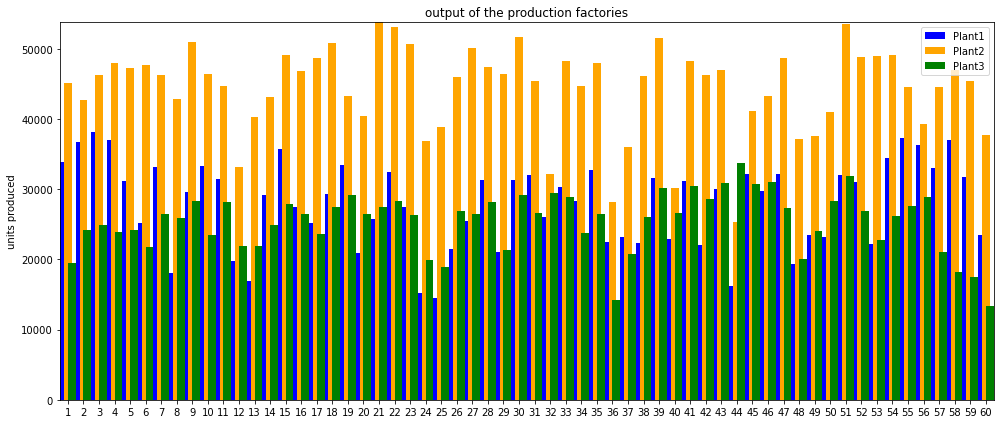

In [9]:
# transform df columns into list objects
Months = list(prod_df["Months"])
Plant1 = list(prod_df["Plant 1"])
Plant2 = list(prod_df["Plant 2"])
Plant3 = list(prod_df["Plant 3"])


x = np.arange(len(Months))  # the label locations
width = 0.50  # the width of the bars

# create bar plot
fig, ax = plt.subplots(figsize=(14, 6))
first = ax.bar(x - width/2, Plant1, width, color="b", label='Plant1')
second = ax.bar(x, Plant2, width, color="orange", label='Plant2')
third = ax.bar(x + width/2, Plant3, width, color="g", label='Plant3')


# adding labels, title and legend
ax.set_ylabel('units produced')
ax.set_title('output of the production factories')
ax.set_xticks(x)
ax.set_xticklabels(Months)
ax.legend()

ax.autoscale(tight=True)

fig.tight_layout()

plt.show()

In [10]:
# statistical key figures evaluation 
prod_df[["Plant 1", "Plant 2", "Plant 3"]].describe()

,Plant 1,Plant 2,Plant 3
count,60.000000,60.000000,60.000000
mean,28037.850000,44418.383333,25441.450000
std,6144.728069,6188.613412,4219.176478
min,14546.000000,25332.000000,13297.000000
25%,23091.750000,41073.000000,23370.750000
50%,29735.000000,46151.000000,26495.500000
75%,32289.000000,48417.500000,28312.000000
max,38211.000000,53782.000000,33676.000000


> - Plant 2 almost always produces the most with an average of 44418.38 units 
> - Plant 1 produces an average of 28037.85 units while Plant 3 produces an average of 25441.45 units

In [11]:
# Reminder: Only months 1 to 51 are historical values (actual values). Months 52 to 60 are planned values (target values). 

### EDA for the transportation dataset

In [12]:
trans_df.head()

,Month,Freight Forwarder,Factory,shipment weight [kg]
0,1,F1,Plant 1,1.004.567
1,1,F1,Plant 3,249.228
2,1,F1,Plant 2,152.674
3,1,F2,Plant 1,781.777
4,1,F2,Plant 3,493.002


In [13]:
trans_df["Freight Forwarder"].unique()

array(['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11',
       'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20',
       'F21', 'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28', 'F29',
       'F30'], dtype=object)

In [14]:
# convert the shipment weight [kg] into numerical values 
temp = []
for row in trans_df["shipment weight [kg]"]:
    row = float(row.replace(".", ""))
    temp.append(row)
trans_df["shipment weight [kg] numerical"] = temp

In [15]:
# convert the shipment weight in kg to tons
temp_2 = []
for num in trans_df["shipment weight [kg] numerical"]:
    row = num/1000
    temp_2.append(row)
trans_df["shipment weight [ton]"] = temp_2

In [16]:
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4160 entries, 0 to 4159
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Month                           4160 non-null   int64  
 1   Freight Forwarder               4160 non-null   object 
 2   Factory                         4160 non-null   object 
 3   shipment weight [kg]            4160 non-null   object 
 4   shipment weight [kg] numerical  4160 non-null   float64
 5   shipment weight [ton]           4160 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 195.1+ KB


In [17]:
# drop column used for calculation 
trans_df.drop(["shipment weight [kg] numerical"], axis=1, inplace=True)

In [18]:
# overview of the total shipment weights for each combination of Freight Forwarder to Factory
pivot_table = pd.pivot_table(trans_df, index=["Freight Forwarder"], columns=["Factory"], values=["shipment weight [ton]"], fill_value=0, margins=True, margins_name="Total shipment weight", aggfunc=np.sum)
pivot_table

shipment weight [ton]                          \
Factory                             Plant 1     Plant 2     Plant 3   
Freight Forwarder                                                     
F1                                29778.169    8829.037   14991.080   
F10                               17930.456   26204.410    6292.876   
F11                                4913.437    1296.189   18484.168   
F12                                 917.986    3175.455     253.267   
F13                               91826.113    5762.644   67605.144   
F14                               68642.438   24796.539   36561.866   
F15                               42704.842    1224.993   36208.723   
F16                               37964.736   56028.703   29183.819   
F17                               19032.884   10421.031    7169.457   
F18                               14500.207    1153.657    7892.374   
F19                               50858.761   10106.838   57731.496   
F2                                30263.044   17095.113   25999.395   
F20                              100382.018    6312.557   84217.928   
F21                                3820.997    1684.122   17759.158   
F22                               54430.072    9340.880   75008.969   
F23                               11380.068    4843.743    3062.477   
F24                               27829.468    7000.334   11626.203   
F25                               20328.655   16643.351   24783.379   
F26                               76089.284    3280.150   61470.400   
F27                                2674.963    1160.313    1466.468   
F28                                   0.000      17.491       0.000   
F29                                 249.151     326.942      11.934   
F3                                64195.215    2485.207   63558.532   
F30                               41796.999   13892.114   57040.579   
F4                                49706.903   19132.676   22913.258   
F5                                83504.923   70909.822   51551.575   
F6                                15018.689   12789.450    6912.621   
F7                                61114.238   11256.634   30242.524   
F8                                17590.891      47.873   10423.244   
F9                                 8679.172    7149.083   19029.143   
Total shipment weight           1048124.779  354367.351  849452.057   

                                             
Factory               Total shipment weight  
Freight Forwarder                            
F1                                53598.286  
F10                               50427.742  
F11                               24693.794  
F12                                4346.708  
F13                              165193.901  
F14                              130000.843  
F15                               80138.558  
F16                              123177.258  
F17                               36623.372  
F18                               23546.238  
F19                              118697.095  
F2                                73357.552  
F20                              190912.503  
F21                               23264.277  
F22                              138779.921  
F23                               19286.288  
F24                               46456.005  
F25                               61755.385  
F26                              140839.834  
F27                                5301.744  
F28                                  17.491  
F29                                 588.027  
F3                               130238.954  
F30                              112729.692  
F4                                91752.837  
F5                               205966.320  
F6                                34720.760  
F7                               102613.396  
F8                                28062.008  
F9                                34857.398  
Total shipment weight           2251944.187

In [19]:
# Freight Forwarder F28 only transports commodities to Plant 2
trans_df[trans_df["Freight Forwarder"]=="F28"]

,Month,Freight Forwarder,Factory,shipment weight [kg],shipment weight [ton]
268,4,F28,Plant 2,650,0.650
909,12,F28,Plant 2,7.378,7.378
1316,17,F28,Plant 2,1.407,1.407
1646,21,F28,Plant 2,8.056,8.056


In [20]:
#number of unique Factorys
trans_df["Factory"].nunique()

3

In [21]:
# number of unique Freight Forwarders
trans_df["Freight Forwarder"].nunique()

30

In [22]:
# 3 factories, supplied by 30 forwarders = 90 possible combinations
3 * 30 

90

In [23]:
# 90 combinations minus 2 x F28 
90 - 2

88

In [24]:
trans_df["Month"].nunique()

51

In [25]:
# total combinations times the number of months
88 * 51

4488

In [26]:
trans_df.shape

(4160, 5)

> Conclusion: Further anomalies (individual combinations). Probably there were monthly dropouts in the supply chain. 

In [27]:
trans_df.set_index("Factory", inplace=True)

In [28]:
# The forwarders with the largest delivery quantity for factory 1
plant1_df = trans_df.loc[["Plant 1"]]
agg_plant1 = plant1_df.groupby("Freight Forwarder").agg({'shipment weight [ton]': ["sum"]})
agg_plant1 = agg_plant1.sort_values([('shipment weight [ton]', 'sum')], ascending=False)
agg_plant1[:5]

,shipment weight [ton]
,sum
Freight Forwarder,
F20,100382.018
F13,91826.113
F5,83504.923
F26,76089.284
F14,68642.438


In [29]:
# The forwarders with the largest delivery quantity for factory 2
plant2_df = trans_df.loc[["Plant 2"]]
agg_plant2 = plant2_df.groupby("Freight Forwarder").agg({'shipment weight [ton]': ["sum"]})
agg_plant2 = agg_plant2.sort_values([('shipment weight [ton]', 'sum')], ascending=False)
agg_plant2[:5]

,shipment weight [ton]
,sum
Freight Forwarder,
F5,70909.822
F16,56028.703
F10,26204.410
F14,24796.539
F4,19132.676


In [30]:
# The forwarders with the largest delivery quantity for factory 3
plant3_df = trans_df.loc[["Plant 3"]]
agg_plant3 = plant3_df.groupby("Freight Forwarder").agg({'shipment weight [ton]': ["sum"]})
agg_plant3 = agg_plant3.sort_values([('shipment weight [ton]', 'sum')], ascending=False)
agg_plant3[:5]

,shipment weight [ton]
,sum
Freight Forwarder,
F20,84217.928
F22,75008.969
F13,67605.144
F3,63558.532
F26,61470.400


> Preliminary finding: While factory 2 produces the most, the least transport weight is transported to this factory. The highest transport weight is transported to factory 1, which, like factory 3, produces significantly less. 

In [31]:
trans_df.reset_index(inplace=True)

In [32]:
# how often does appear the single Freight Forwarders in the data  
trans_df["Freight Forwarder"].value_counts()

F4     153
F17    153
F2     153
F27    153
F13    153
F6     153
F8     153
F7     153
F1     153
F14    153
F19    153
F3     153
F9     153
F22    153
F18    153
F15    153
F11    153
F5     153
F23    153
F25    153
F24    153
F16    153
F20    153
F26    153
F10    153
F12    134
F30    109
F29     47
F21     41
F28      4
Name: Freight Forwarder, dtype: int64

> The forwarders F12, F30, F29, F21 and F28 show supply bottlenecks. 

In [33]:
trans_df["Factory"].value_counts()

Plant 2    1393
Plant 1    1387
Plant 3    1380
Name: Factory, dtype: int64

### Outlier detection 

<AxesSubplot:xlabel='shipment weight [ton]'>

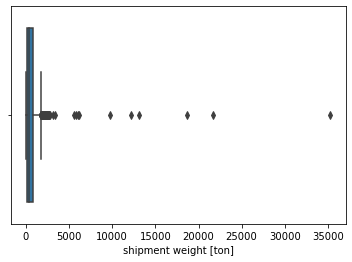

In [34]:
sns.boxplot(trans_df["shipment weight [ton]"])

In [35]:
trans_df.loc[trans_df["shipment weight [ton]"] > 35000]

,Factory,Month,Freight Forwarder,shipment weight [kg],shipment weight [ton]
3105,Plant 1,39,F7,35.267.115,35267.115


In [36]:
F7 = trans_df.loc[trans_df["Freight Forwarder"] == "F7"]
F7.describe()

,Month,shipment weight [ton]
count,153.000000,153.000000
mean,26.000000,670.675791
std,14.767942,2873.570281
min,1.000000,68.742000
25%,13.000000,246.342000
50%,26.000000,341.175000
75%,39.000000,481.392000
max,51.000000,35267.115000


Text(0.5, 1.0, 'F7 - Plant1 - Monthly Shipments Weight [kg]')

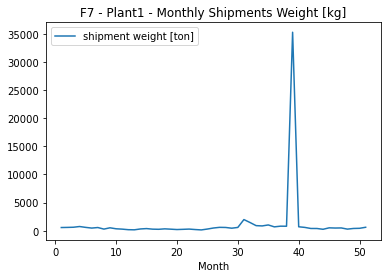

In [37]:
# the figure for the combinations F7 - Plant1
trans_df.set_index("Factory", inplace=True)
Plant1 = trans_df.loc[["Plant 1"]]
Plant1.reset_index(inplace=True)
Plant1.set_index("Freight Forwarder", inplace=True)
Plant1_F7_MainLeg = Plant1.loc[["F7"]]
Plant1_F7_MainLeg.plot.line(x="Month", y="shipment weight [ton]")
plt.title("F7 - Plant1 - Monthly Shipments Weight [kg]")

> The forwarder F7 probably did not transport 35267,115 tons of shipment weight only in one month (month 39), when in 75% of all cases he didn't transport more than 481,392 tons.

## Forecast of future shipment weights 

Machine learning and deep learning methods are often reported to be the key solution to all predictive modeling problems.<br> An important recent study evaluated that simple classical methods, such as linear methods and exponential smoothing, outperform complex and sophisticated methods, such as Multilayer Perceptrons (MLP) and Long Short-Term Memory (LSTM) network models.<br>
These findings highlight the requirement to both evaluate classical methods and use their results as a baseline when evaluating any machine learning and deep learning methods for time series forecasting in order demonstrate that their added complexity is adding skill to the forecast.<br>

Spyros Makridakis, et al. published a study in 2018 titled “Statistical and Machine Learning forecasting methods: Concerns and ways forward.”<br>
Key findings in that study:
- Classical methods like ETS and ARIMA out-perform machine learning and deep learning methods for one-step forecasting on univariate datasets.
- Classical methods like Theta and ARIMA out-perform machine learning and deep learning methods for multi-step forecasting on univariate datasets.
- Machine learning and deep learning methods do not yet deliver on their promise for univariate time series forecasting and there is much work to do.

## Time Series Analysis 

In [38]:
# prepare data for single combination F1 - Plant 1
p1_f1 = trans_df.loc[["Plant 1"]]
p1_f1.reset_index(inplace=True)
p1_f1.set_index("Freight Forwarder", inplace=True)
p1_f1 = p1_f1.loc[["F1"]]
p1_f1.set_index("Month", inplace=True)
p1_f1.drop(["Factory", "shipment weight [kg]"], axis=1, inplace=True)
p1_f1["shipment weight [ton]"] = pd.to_numeric(p1_f1["shipment weight [ton]"])

#### In order to analyse time series data, we need values with a timestamp. <br>
Because our data of 60 months are 5 years in total, I decided to change the months to datetime objects starting at April 2016 until this month (April 2021). 

In [39]:
# 60 Monate sind 5 Jahre. Von heute bis April 2016.
p1_f1["dates"] = pd.date_range("04, 2016", periods=51, freq="M")
p1_f1.set_index("dates", inplace=True)
p1_f1.index.freq="M"
p1_f1[:5]

,shipment weight [ton]
dates,
2016-04-30,1004.567
2016-05-31,983.519
2016-06-30,864.972
2016-07-31,740.641
2016-08-31,716.764


<AxesSubplot:title={'center':'F1 - Plant1 - Monthly Shipment Weights[ton]'}, xlabel='dates', ylabel='weights[ton]'>

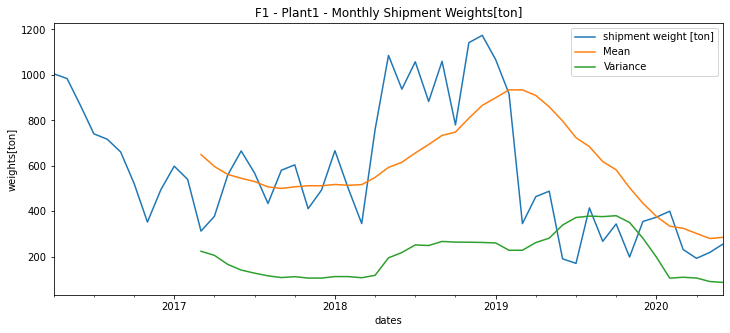

In [40]:
title="F1 - Plant1 - Monthly Shipment Weights[ton]"
ylabel="weights[ton]"
xlabel="dates"

ax = p1_f1.plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);
p1_f1["shipment weight [ton]"].rolling(12).mean().plot(label="Mean", legend=True)
p1_f1["shipment weight [ton]"].rolling(12).std().plot(label="Variance", legend=True)

### ETS Decomposition

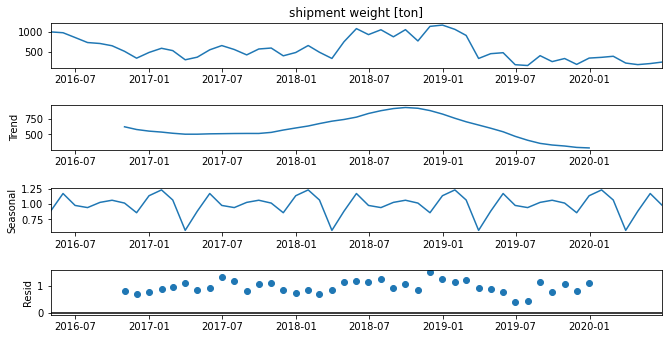

In [41]:
# ETS decompose the time series into 3 components: 
# Overall trend, seasonal factors and residuals(erros not explained by seasonality or trend)
result = seasonal_decompose(p1_f1["shipment weight [ton]"], model='mul').plot()
result.set_size_inches(10, 5)

> This time series seems to have no strong trend but some seasonality factors

Before we use ARIMA based models, we need to determine if the time series is stationary. The TS data is stationary, if it does not exhibit trends or seasonality. From the ETS Decomposition we would assume the TS has some seasonality, which means it's non-stationary. We can test this quantitatively by using the Dickey-Fuller Test. 

In [42]:
ad_fuller_test = sm.tsa.stattools.adfuller(p1_f1["shipment weight [ton]"], autolag="AIC")
print("The p-value is:", ad_fuller_test[1])

The p-value is: 0.14083334200699998


> A p-value > 0.05 indicates non-stationarity 

Because the data is non-stationary we continue doing differencing to make the data stationary by shifting the original data by 1 and taking the difference for each row between original and shifted data.

In [43]:
p1_f1["First Difference"] = p1_f1["shipment weight [ton]"] - p1_f1["shipment weight [ton]"].shift(1)

In [44]:
# check again for stationarity with the Dickey-Fuller test
p1_f1.dropna(inplace=True)
ad_fuller_test = sm.tsa.stattools.adfuller(p1_f1["First Difference"], autolag="AIC")
print("The p-value is:", ad_fuller_test[1])

The p-value is: 8.523889880170025e-12


In [45]:
p1_f1["Second Difference"] = p1_f1["shipment weight [ton]"] - p1_f1["shipment weight [ton]"].shift(2)

In [46]:
# check again for stationarity with the Dickey-Fuller test
p1_f1.dropna(inplace=True)
ad_fuller_test = sm.tsa.stattools.adfuller(p1_f1["Second Difference"], autolag="AIC")
print("The p-value is:", ad_fuller_test[1])

The p-value is: 0.024354744499853954


### Seasonal Autoregressive Integrated Moving-Average (SARIMA)

The SARIMA method combines the ARIMA model with the ability to perform the same autoregression, differencing, and moving average modeling at the seasonal level.

The method is suitable for univariate time series with trend and/or seasonal components.

SARIMA = p, d, q, P, D, Q, S

ARIMA = p, d, q

In [47]:
# check Moving Average (q)

In [48]:
model_ma = sm.tsa.statespace.SARIMAX(p1_f1["Second Difference"], order=(0,0,1))

In [49]:
results_ma = model_ma.fit()

In [50]:
results_ma.aic

644.0680151298991

In [51]:
# check AutoRegression (p)

In [52]:
model_RA = sm.tsa.statespace.SARIMAX(p1_f1["Second Difference"], order=(1,0,0))

In [53]:
results_RA = model_RA.fit()

In [54]:
results_RA.aic

662.044657348569

In [55]:
# check ARMA (p, q)

In [56]:
model_ARma = sm.tsa.statespace.SARIMAX(p1_f1["Second Difference"], order=(1,0,1))

In [57]:
results_ARma = model_ARma.fit()

In [58]:
results_ARma.aic

645.1288141232674

In [59]:
# check ARIMA (p,d,q)

In [60]:
model_ARima = sm.tsa.statespace.SARIMAX(p1_f1["Second Difference"], order=(1,1,1))

In [61]:
results_ARima = model_ARima.fit()

In [62]:
results_ARima.aic

653.9908147474673

In [63]:
# GridSearch to determine the best combination of ARIMA components by the lowest AIC 

In [64]:
p=d=q=P=D=Q = range(0,3)
S=12

In [65]:
combinations = list(itertools.product(p,d,q,P,D,Q))

In [66]:
arima_order = [(x[0], x[1], x[2]) for x in combinations]

In [67]:
seasonal_orders = [(x[3], x[4], x[5], S) for x in combinations]

In [68]:
results_data = pd.DataFrame(columns=["p", "d", "q", "P", "D", "Q", "AIC"])

In [69]:
for i in range(len(combinations)):
    try:
        model = sm.tsa.statespace.SARIMAX(p1_f1["Second Difference"], order=arima_order[i], seasonal=seasonal_orders[i])
        result = model.fit()
        results_data.loc[i, "p"] = arima_order[i][0]
        results_data.loc[i, "d"] = arima_order[i][1]
        results_data.loc[i, "q"] = arima_order[i][2]
        results_data.loc[i, "P"] = seasonal_orders[i][0]
        results_data.loc[i, "D"] = seasonal_orders[i][1]
        results_data.loc[i, "Q"] = seasonal_orders[i][2]
        results_data.loc[i, "AIC"] = result.aic
    except:
        continue

In [70]:
results_data[results_data.AIC == min(results_data.AIC)][-1:]

,p,d,q,P,D,Q,AIC
161,0,1,2,2,2,2,635.918


> The best model with the lowest AIC of 635.918 has the order 0,1,2,2,2,2,12

In [71]:
best_model = sm.tsa.statespace.SARIMAX(p1_f1["Second Difference"], order=(0,1,2), seasonal_order=(2,2,2,12))

In [72]:
results = best_model.fit()

In [73]:
results.aic

356.5163014571923

In [74]:
# forecast with seasonal arima 

In [75]:
fitting = results.get_prediction(start="2016-07-31")

In [76]:
fitting_mean = fitting.predicted_mean

In [77]:
forecast = results.get_forecast(steps=9)

In [78]:
forecast_mean = forecast.predicted_mean

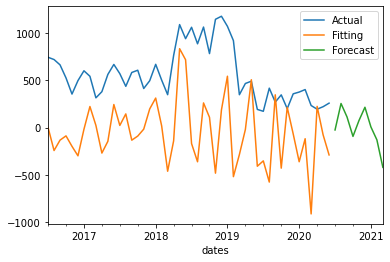

In [79]:
p1_f1["shipment weight [ton]"].plot(label="Actual")
#p1_f1["Second Difference"].plot()
fitting_mean.plot(label="Fitting")
forecast_mean.plot(label="Forecast")
plt.legend()

### MAPE Evaluation Metric

In [80]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [81]:
mean_absolute_percentage_error(p1_f1["shipment weight [ton]"], fitting_mean)

126.63449259787166

### Holt Winter’s Exponential Smoothing 

In [82]:
# prepare data for single combination F1 - Plant 1
p1_f1 = trans_df.loc[["Plant 1"]]
p1_f1.reset_index(inplace=True)
p1_f1.set_index("Freight Forwarder", inplace=True)
p1_f1 = p1_f1.loc[["F1"]]
p1_f1.set_index("Month", inplace=True)
p1_f1.drop(["Factory", "shipment weight [kg]"], axis=1, inplace=True)
p1_f1["shipment weight [ton]"] = pd.to_numeric(p1_f1["shipment weight [ton]"])

In [83]:
df = p1_f1[["shipment weight [ton]"]]
df["dates"] = pd.date_range("04, 2016", periods=51, freq="M")

In [84]:
df.set_index("dates", inplace=True)

In [85]:
# split data in train-/test sets 
train = df.iloc[:43]
test = df.iloc[42:]

In [86]:
fitted_model = ExponentialSmoothing(train["shipment weight [ton]"],trend="mul", seasonal="mul", seasonal_periods=12).fit()

In [87]:
test_predictions = fitted_model.forecast(9)
test_predictions

2019-11-30    344.025949
2019-12-31    355.820109
2020-01-31    387.645880
2020-02-29    330.557735
2020-03-31    182.815006
2020-04-30    324.292759
2020-05-31    403.830348
2020-06-30    339.455322
2020-07-31    361.193994
Freq: M, dtype: float64

<AxesSubplot:xlabel='dates'>

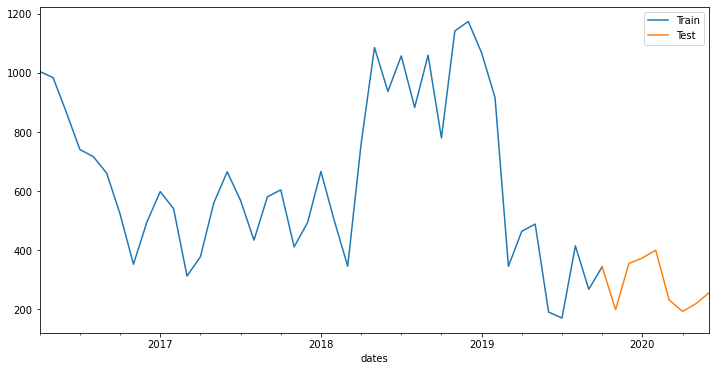

In [88]:
# train vs. test data 
train["shipment weight [ton]"].plot(legend=True, label="Train", figsize=(12, 6))
test["shipment weight [ton]"].plot(legend=True, label="Test")

<AxesSubplot:xlabel='dates'>

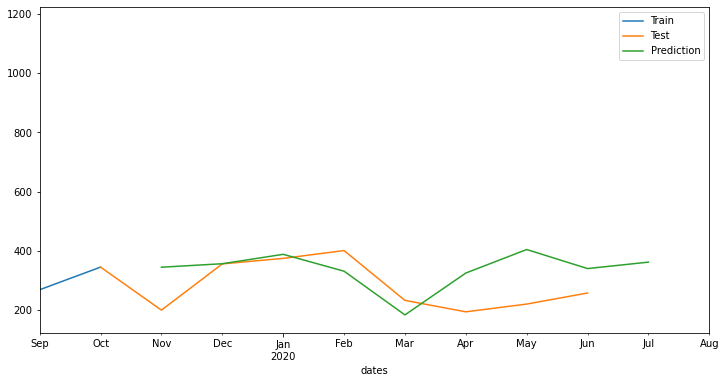

In [89]:
# test data vs. predictions
train["shipment weight [ton]"].plot(legend=True, label="Train", figsize=(12, 6))
test["shipment weight [ton]"].plot(legend=True, label="Test")
test_predictions.plot(legend=True, label="Prediction", xlim=["2019-09", "2020-08"]) # Limit value range on the x-axis 

In [90]:
mean_absolute_percentage_error(test, test_predictions)

37.88573164045411

### Forecast future values

<AxesSubplot:xlabel='dates'>

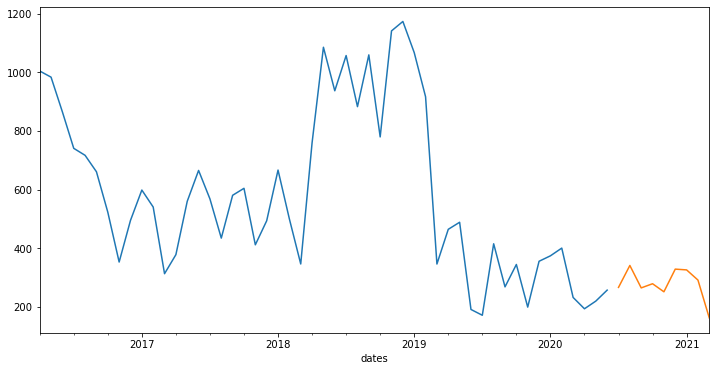

In [91]:
# training with every data point 
final_model = ExponentialSmoothing(df["shipment weight [ton]"], trend="mul", seasonal="mul", seasonal_periods=12).fit()

# predict 9 months into the future
forecast_predictions = final_model.forecast(9)

df["shipment weight [ton]"].plot(figsize=(12, 6))
forecast_predictions.plot()

### Deep Learning: Recurrent Neural Networks 

In [92]:
len(p1_f1)

51

In [93]:
51-9

42

In [94]:
# Train Test Split
train = p1_f1.iloc[:42]
test = p1_f1.iloc[42:]

In [95]:
len(test)

9

In [96]:
# Scale data
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [97]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

### Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

In [98]:
# define generator
n_input = 2
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [99]:
len(scaled_train)

42

In [100]:
len(generator) # n_input = 2

40

In [101]:
scaled_train[:3]

array([[0.83145115],
       [0.81045499],
       [0.69219996]])

In [102]:
# What does the first batch look like?
X,y = generator[0]

In [103]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.83145115 0.81045499]
Predict this y: 
 [[0.69219996]]


In [104]:
# redefine to get 9 months back and then predict the next month out
n_input = 9
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [105]:
# What does the first batch look like?
X,y = generator[0]

In [106]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.83145115 0.81045499 0.69219996 0.56817518 0.54435698 0.48844104
 0.35094153 0.18119862 0.3229666 ]
Predict this y: 
 [[0.42618176]]


In [107]:
# create the model
import tensorflow as tf

In [108]:
# set random seed
tf.random.set_seed(42)

# define model
model = Sequential()

model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(5, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))

# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), loss='mae') # Adam or SGD

In [109]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 9, 100)            40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 9, 10)             4440      
_________________________________________________________________
lstm_2 (LSTM)                (None, 5)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 45,566
Trainable params: 45,566
Non-trainable params: 0
_________________________________________________________________


In [110]:
# fit model
model.fit_generator(generator,epochs=100, verbose=0)

Instructions for updating:
Please use Model.fit, which supports generators.


In [111]:
model.history.history.keys()

dict_keys(['loss'])

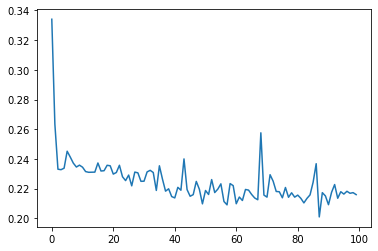

In [112]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [113]:
# evaluate on test data 

In [114]:
first_eval_batch = scaled_train[-9:]

In [115]:
first_eval_batch.shape

(9, 1)

In [116]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [117]:
model.predict(first_eval_batch)

array([[0.3175592]], dtype=float32)

In [118]:
scaled_test[0]

array([0.17286121])

Now let's put this logic in a for loop to predict into the future for the entire test range.

----

In [119]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [120]:
current_batch.shape

(1, 9, 1)

In [121]:
current_batch

array([[[0.89399672],
        [0.74375966],
        [0.17440739],
        [0.29255468],
        [0.31659233],
        [0.01977717],
        [0.        ],
        [0.2432983 ],
        [0.09663341]]])

In [122]:
np.append(current_batch[:,1:,:],[[[99]]],axis=1)

array([[[7.43759657e-01],
        [1.74407388e-01],
        [2.92554682e-01],
        [3.16592334e-01],
        [1.97771702e-02],
        [0.00000000e+00],
        [2.43298297e-01],
        [9.66334121e-02],
        [9.90000000e+01]]])

In [123]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [124]:
test_predictions

[array([0.3175592], dtype=float32),
 array([0.3175592], dtype=float32),
 array([0.56275487], dtype=float32),
 array([0.59636575], dtype=float32),
 array([0.594421], dtype=float32),
 array([0.7649301], dtype=float32),
 array([0.8239527], dtype=float32),
 array([0.5717869], dtype=float32),
 array([0.59647256], dtype=float32)]

In [125]:
scaled_test

array([[0.17286121],
       [0.0277864 ],
       [0.18378124],
       [0.20232646],
       [0.22862652],
       [0.06071011],
       [0.02209744],
       [0.04820897],
       [0.08559866]])

In [126]:
# Inverse Transformations and Compare

In [127]:
true_predictions = scaler.inverse_transform(test_predictions)

In [128]:
true_predictions

array([[489.40626614],
       [489.40626614],
       [735.20731123],
       [768.90117687],
       [766.95165461],
       [937.88174154],
       [997.05001402],
       [744.2616223 ],
       [769.00825211]])

In [129]:
test['Predictions'] = true_predictions

In [130]:
test

,shipment weight [ton],Predictions
Month,,
43,344.351,489.406266
44,198.918,489.406266
45,355.298,735.207311
46,373.889,768.901177
47,400.254,766.951655
48,231.923,937.881742
49,193.215,997.050014
50,219.391,744.261622
51,256.873,769.008252


In [131]:
y_true=test["shipment weight [ton]"]
y_pred=test["Predictions"]

mean_absolute_percentage_error(y_true, y_pred)

183.48765675148857

<AxesSubplot:xlabel='Month'>

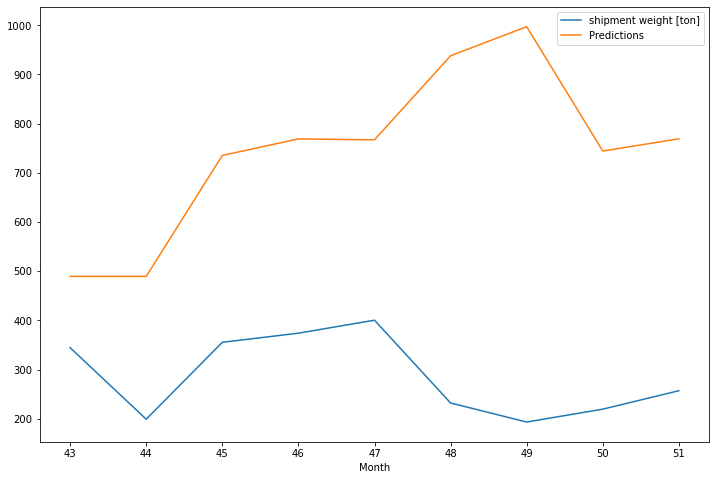

In [132]:
test.plot(figsize=(12,8))

In [133]:
# Saving and loading models

In [134]:
model.save('my_rnn_model.h5')

In [135]:
# load a model

In [136]:
new_model = load_model('my_rnn_model.h5')

In [137]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 9, 100)            40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 9, 10)             4440      
_________________________________________________________________
lstm_2 (LSTM)                (None, 5)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 45,566
Trainable params: 45,566
Non-trainable params: 0
_________________________________________________________________


### Compare model performance by forecasting the next 9 months on univariate time series data
#### Evaluation metric: Mean Absolute Percentage Error
---
- SARIMA: 126.63449259787166
- ExpSmoothing: 37.88573164045411
- RNN: 100.62069563615827

### Forecast each Freight Fowarder - Factory combination with Exponential Smoothing Algorithm 

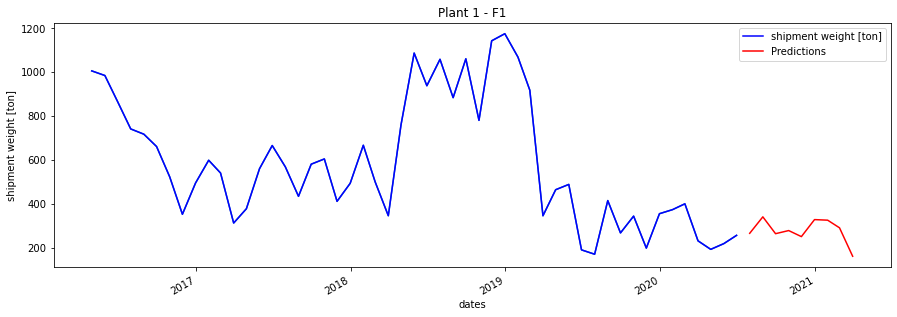

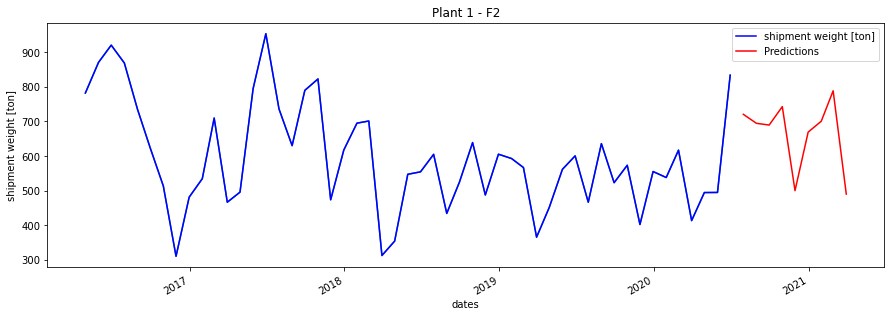

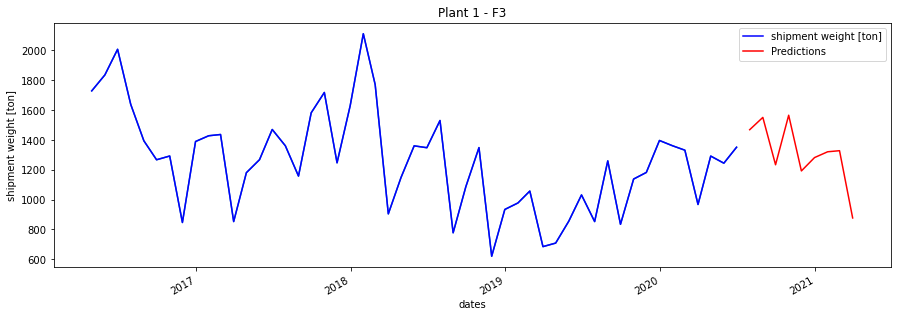

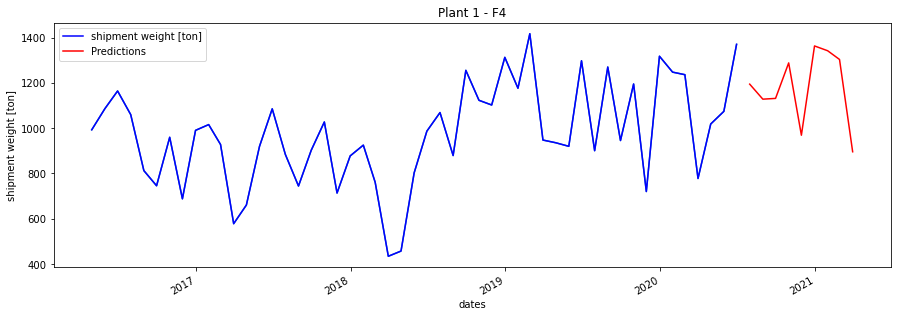

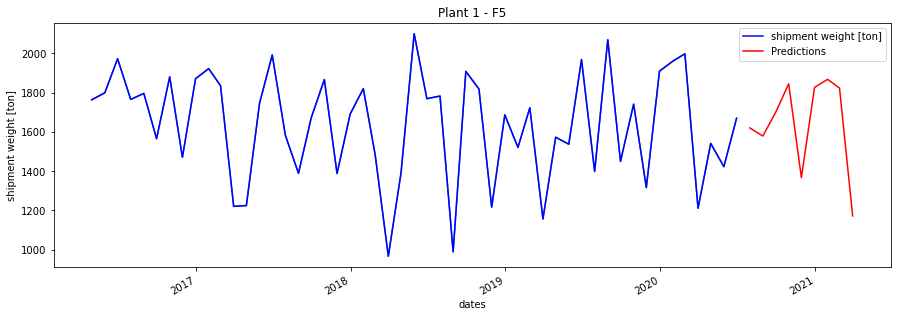

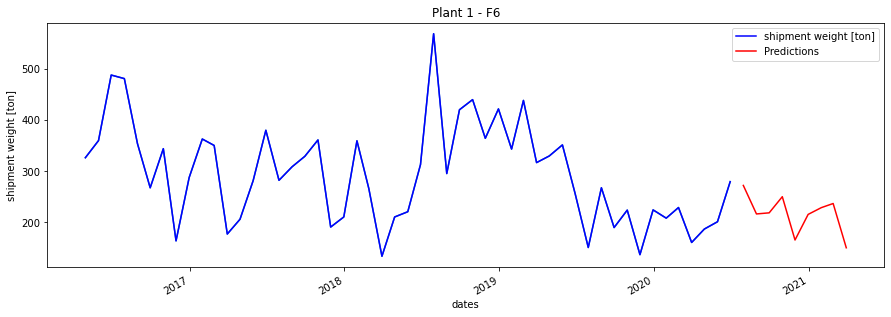

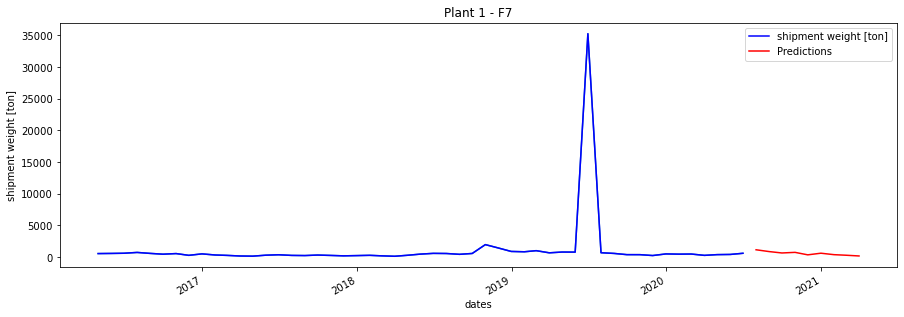

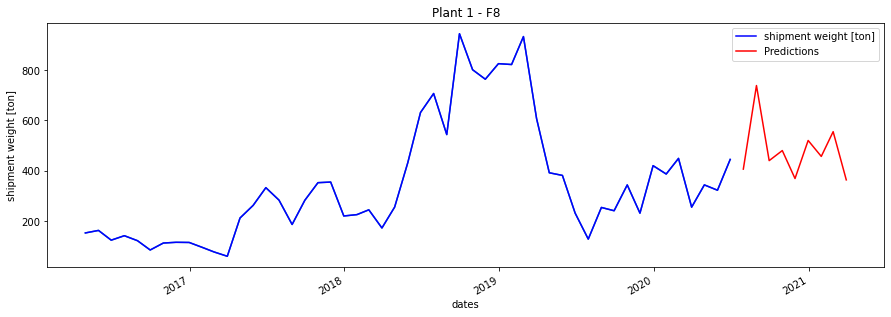

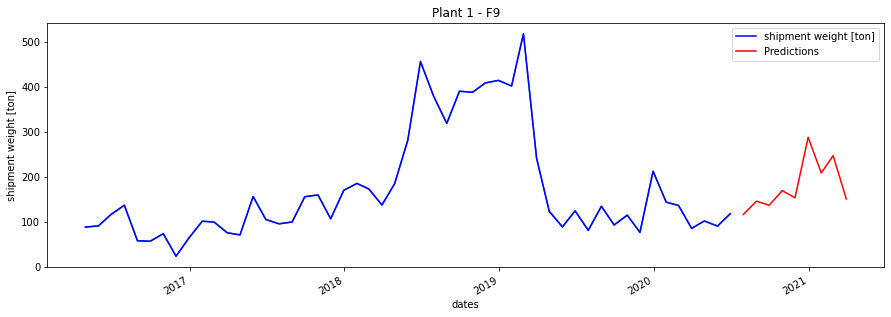

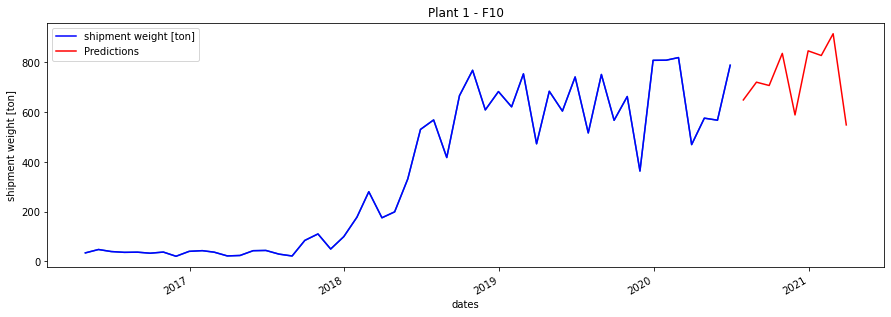

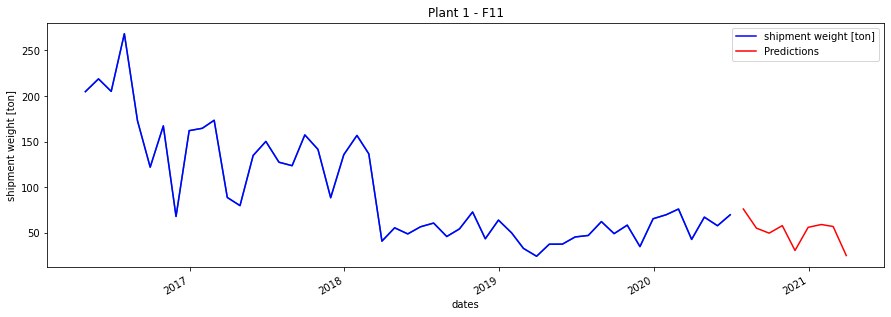

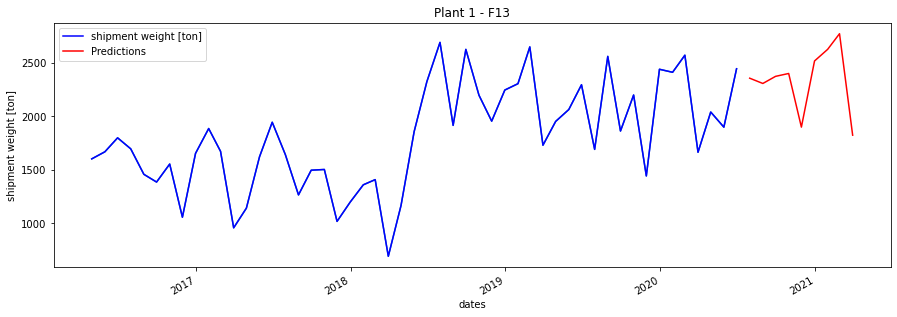

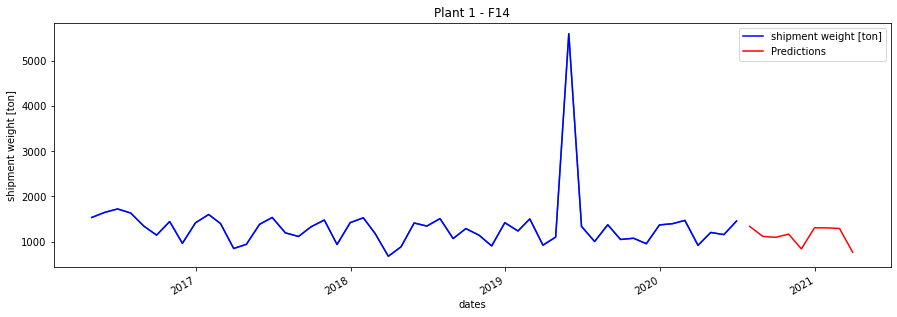

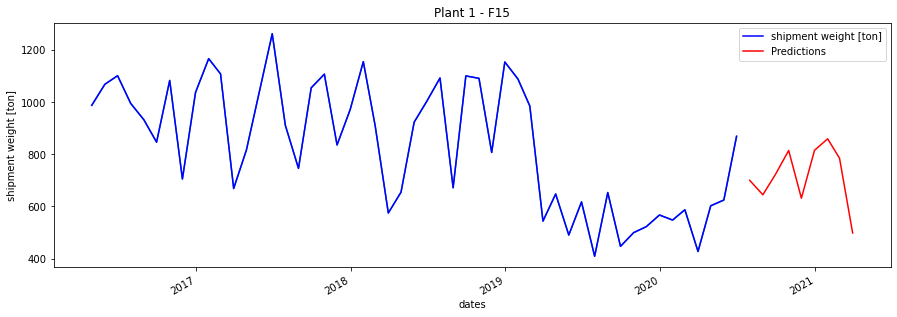

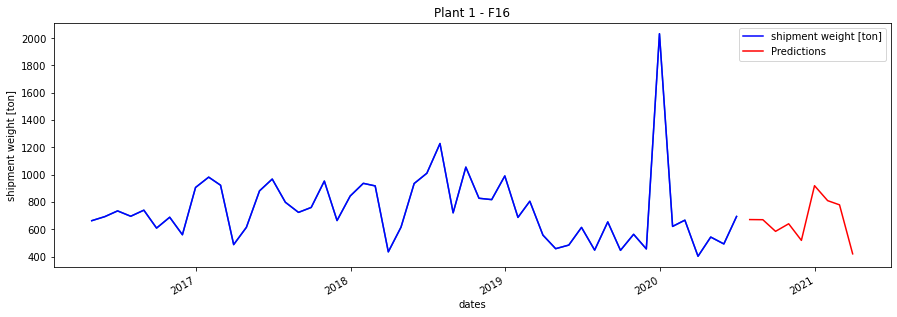

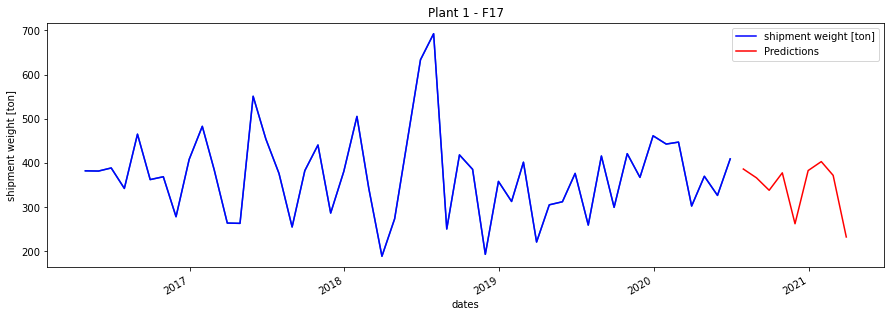

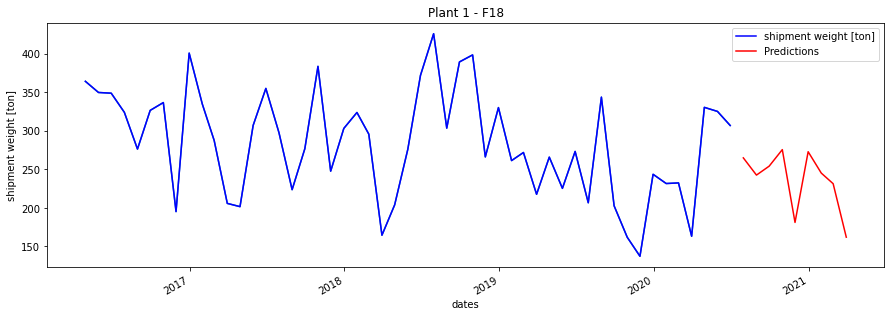

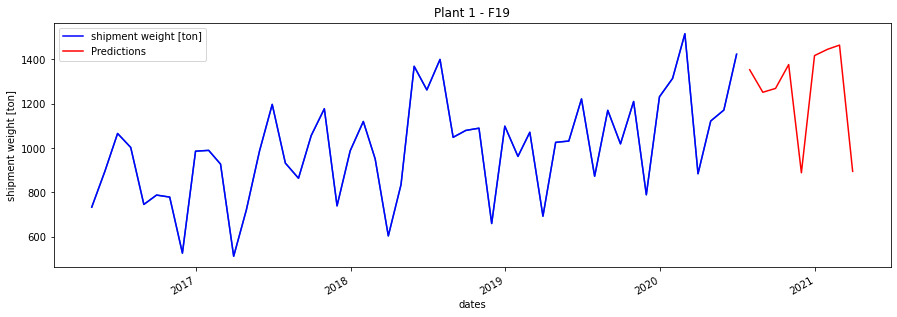

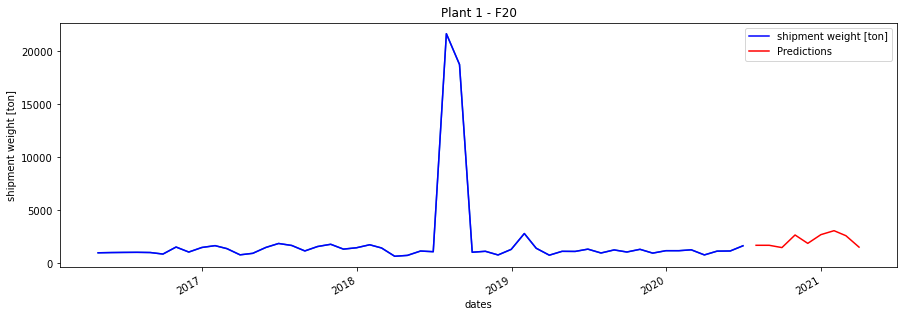

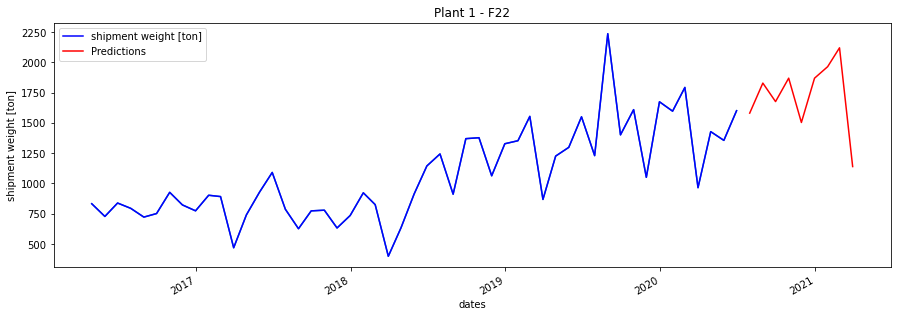

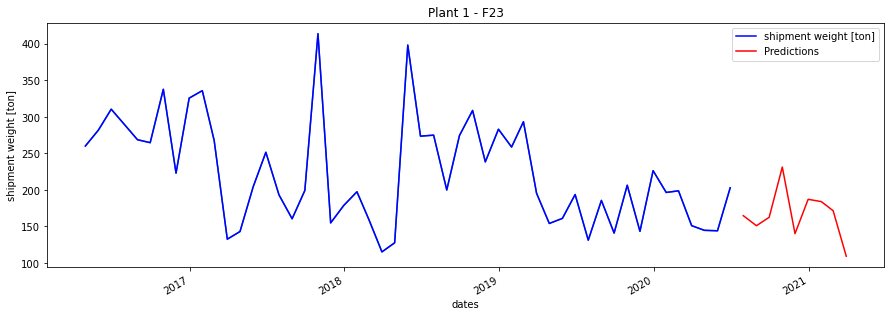

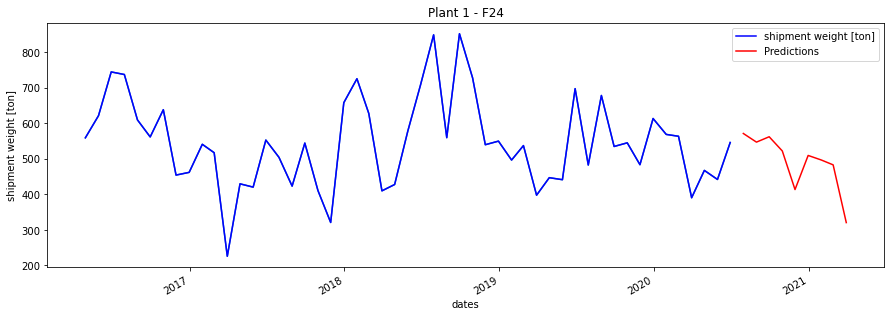

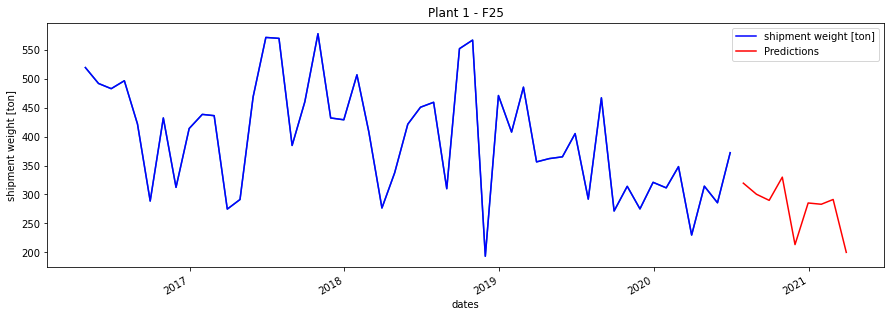

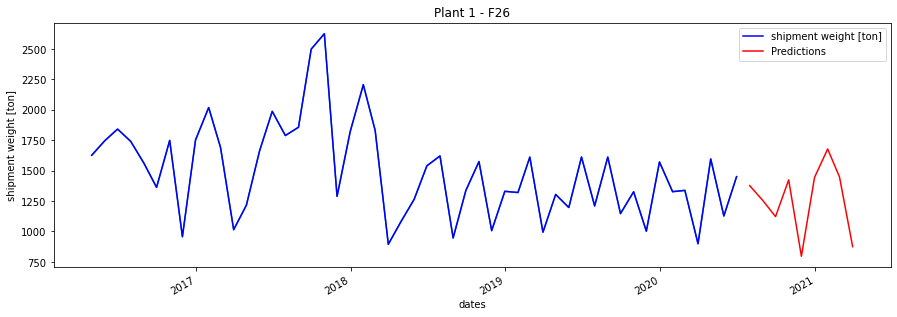

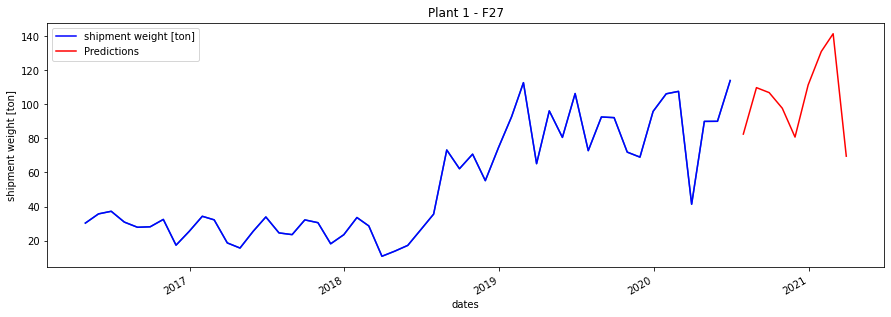

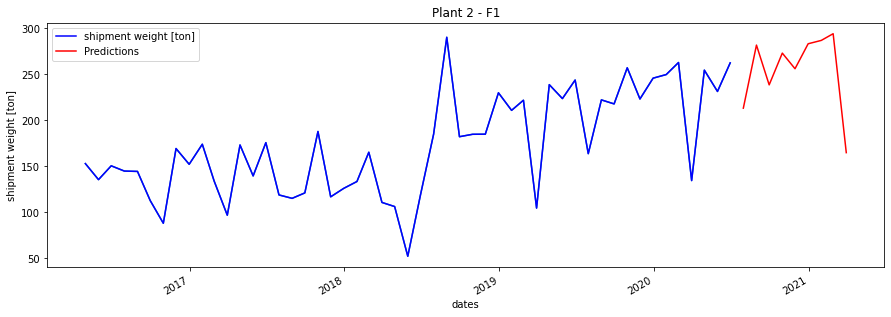

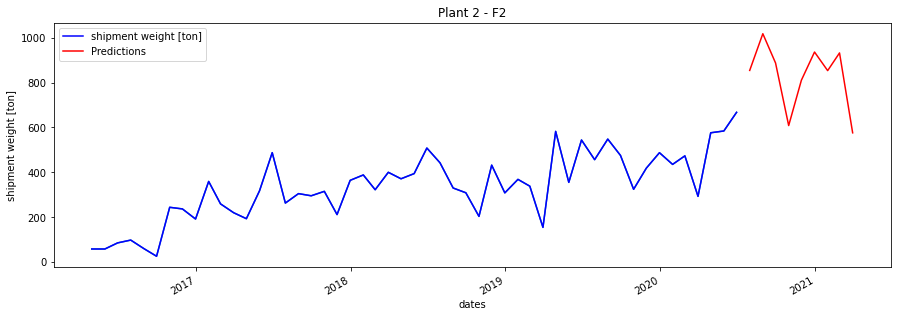

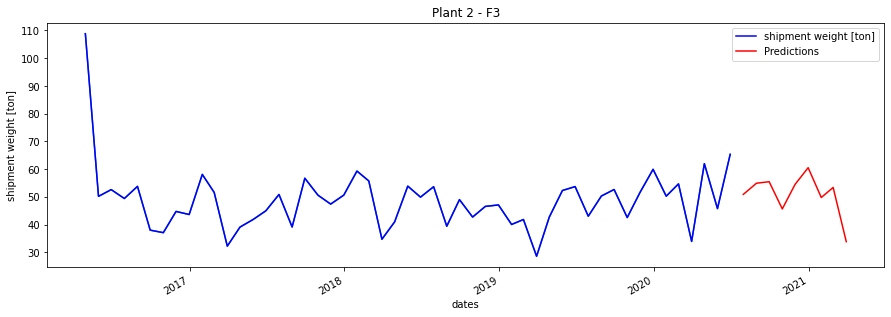

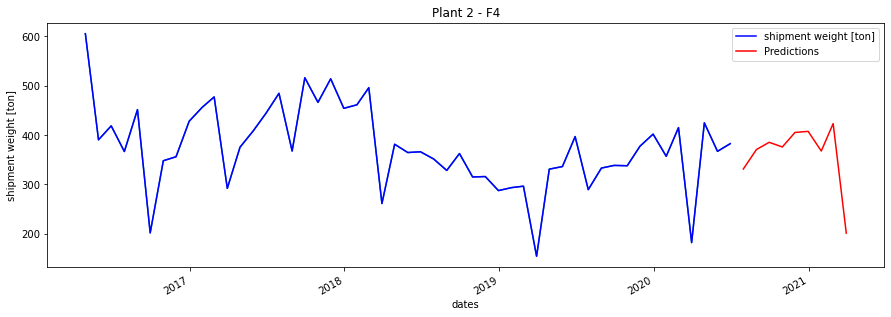

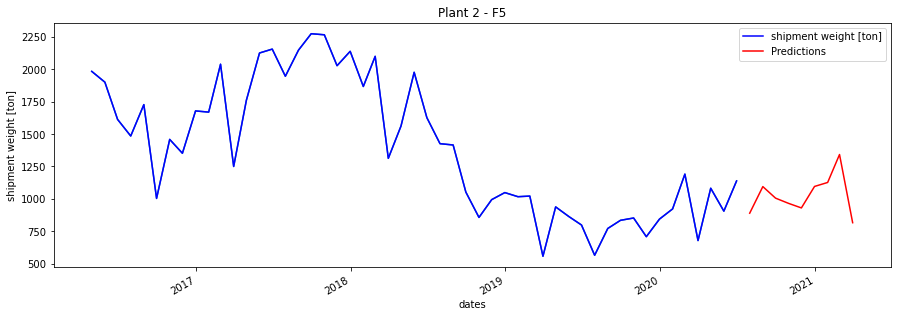

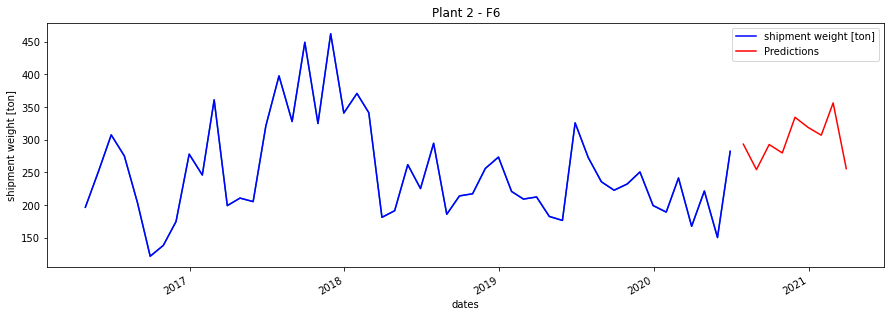

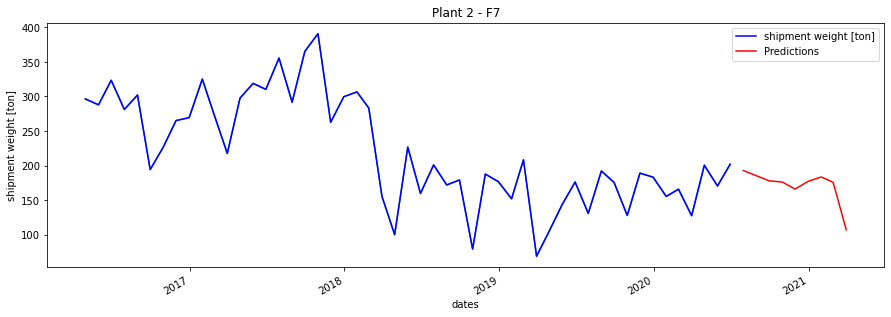

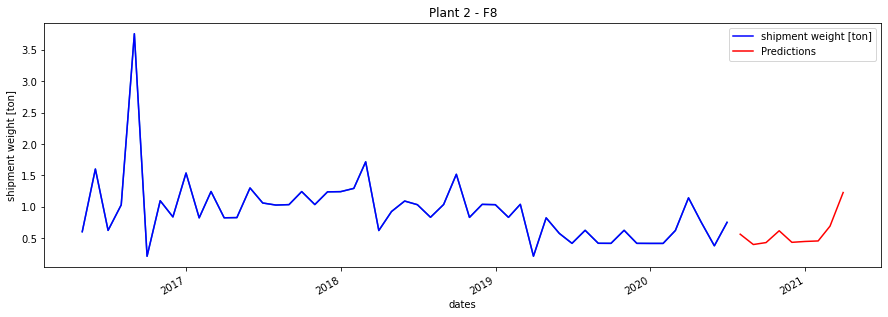

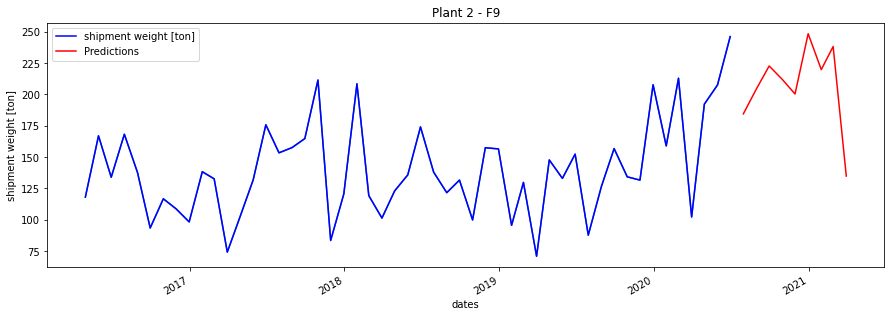

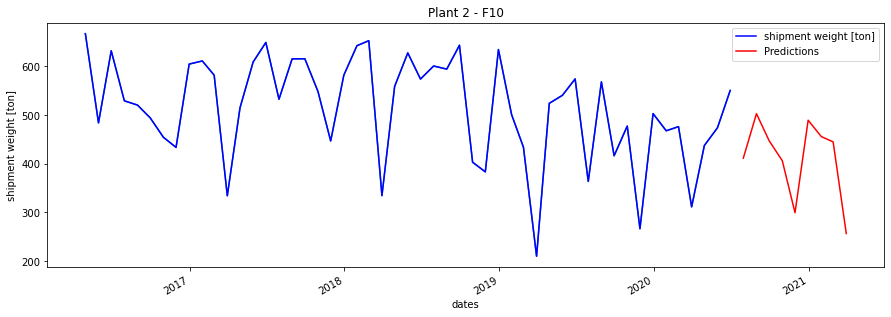

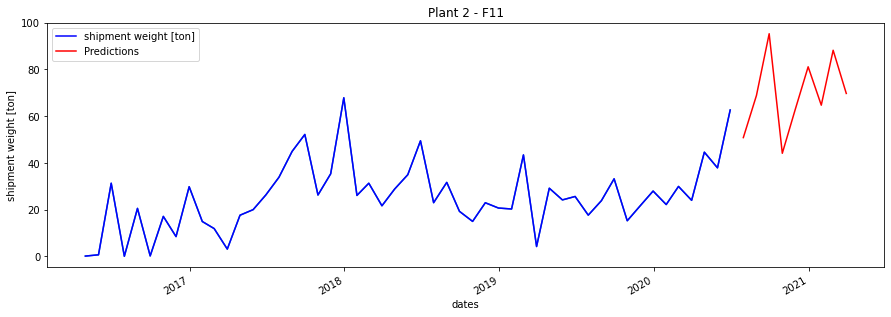

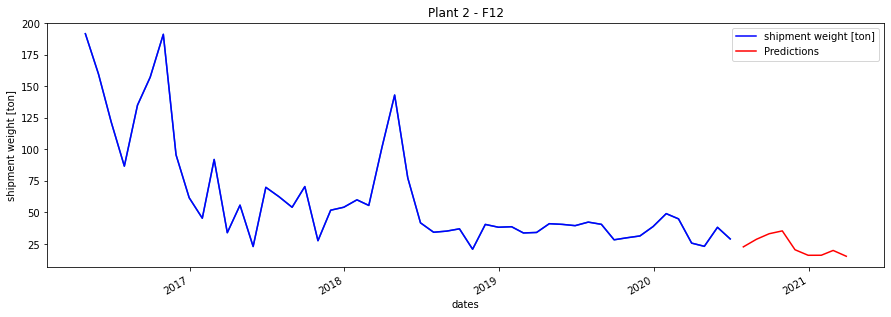

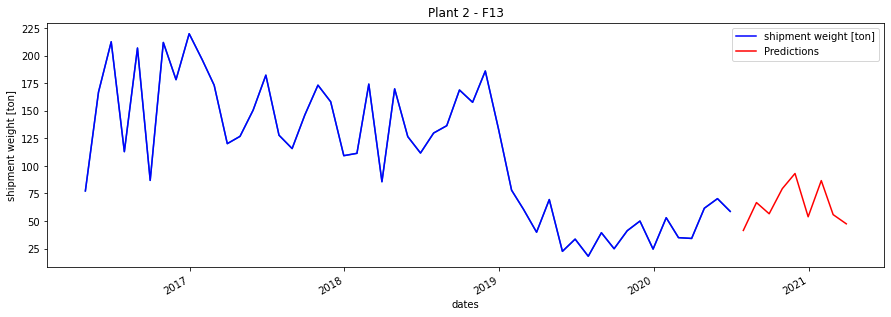

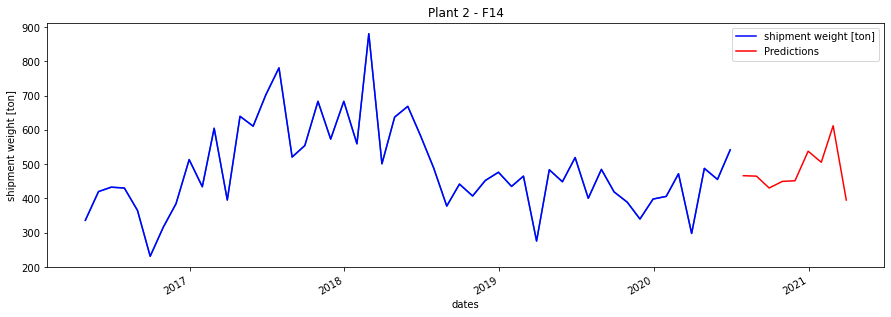

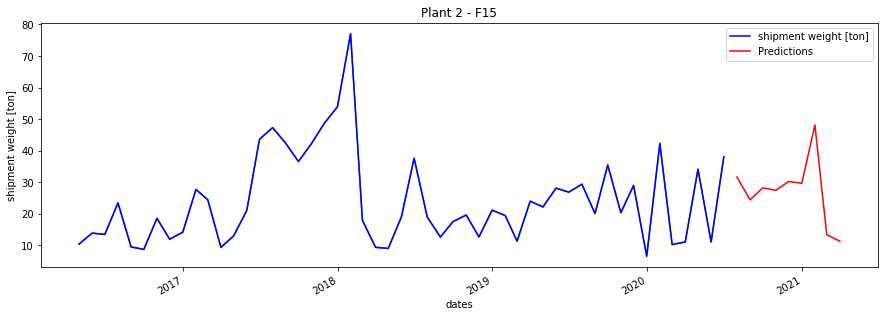

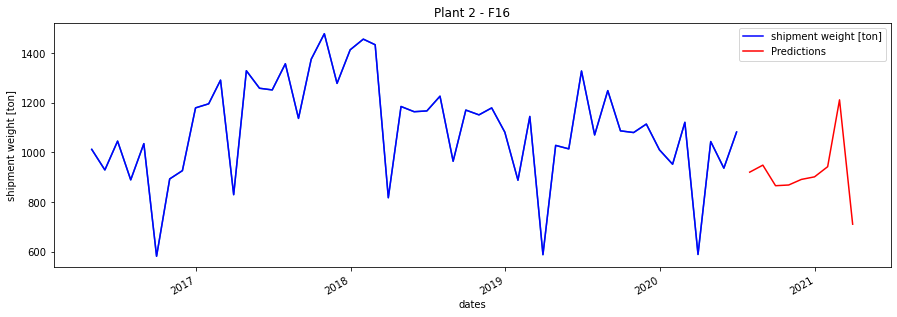

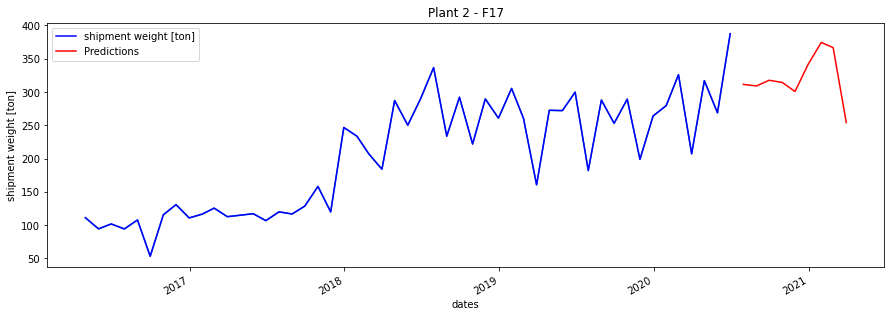

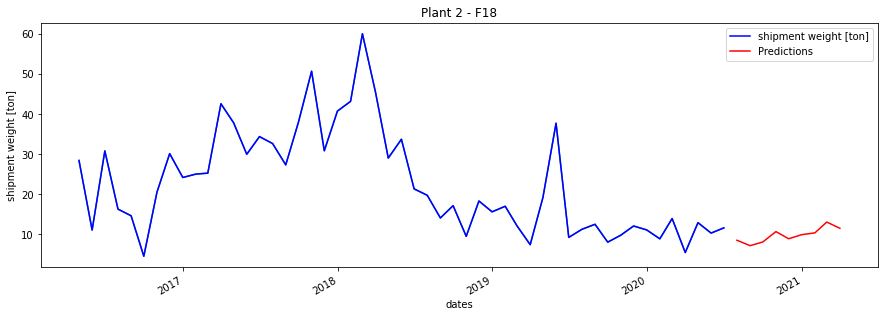

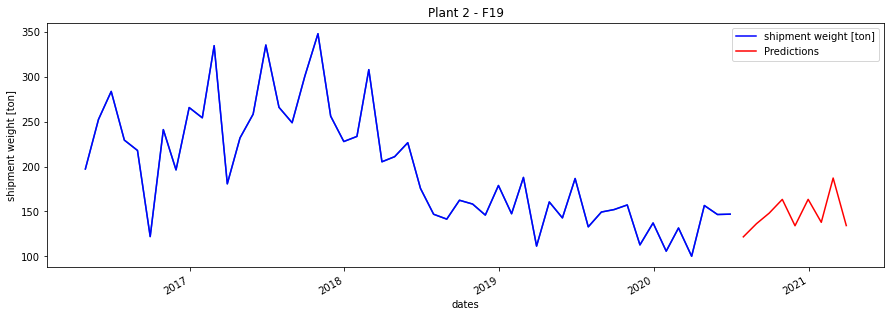

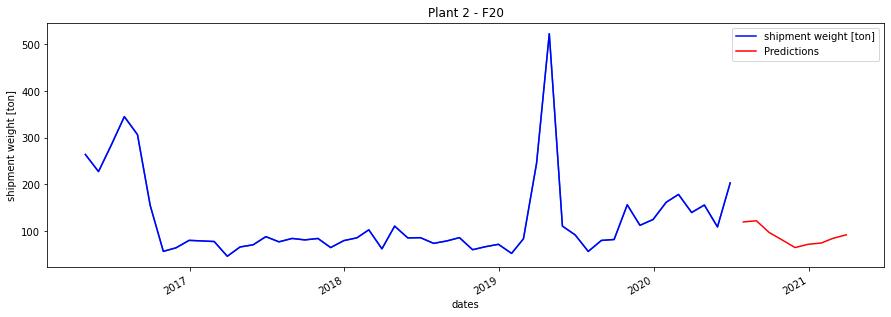

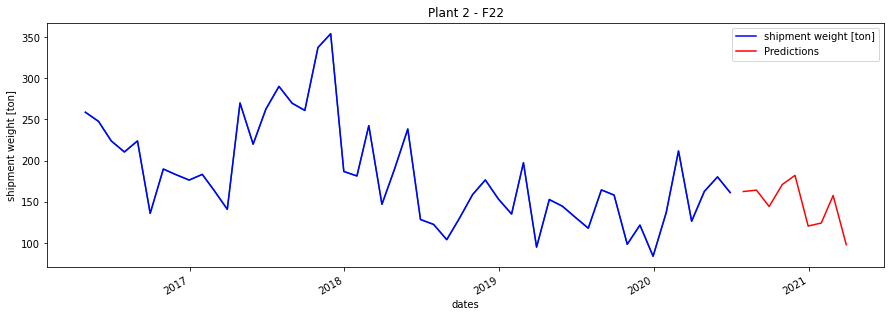

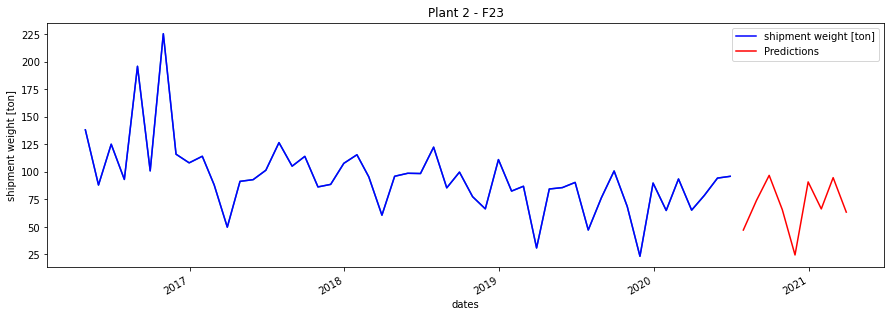

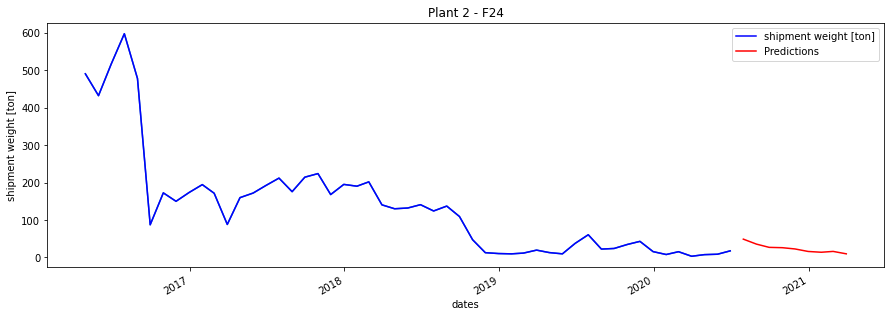

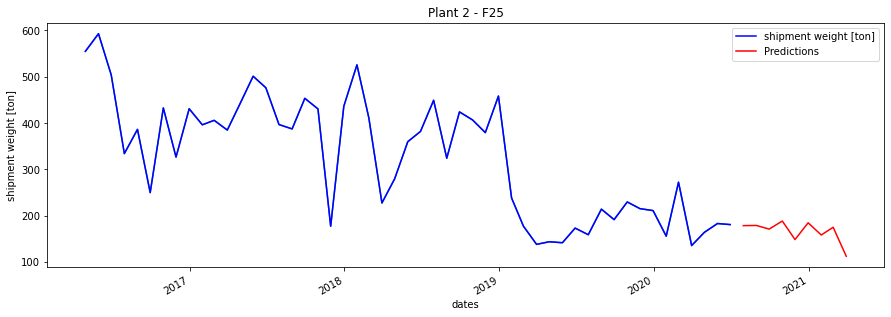

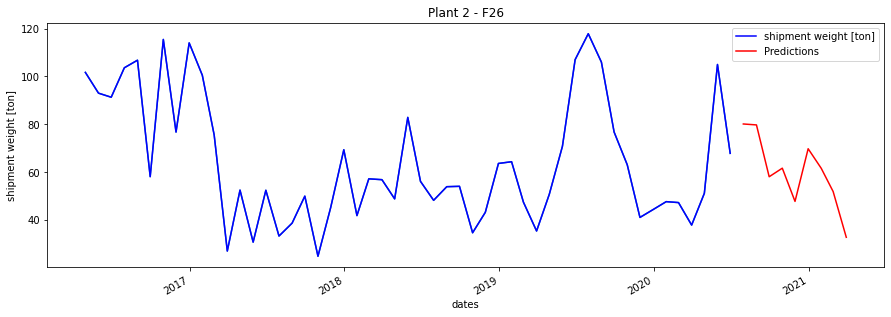

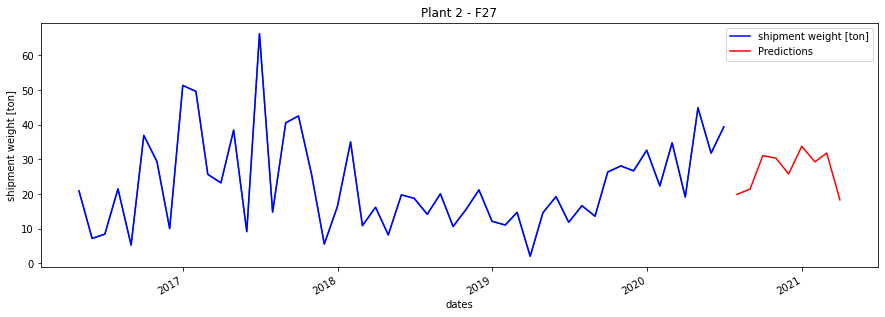

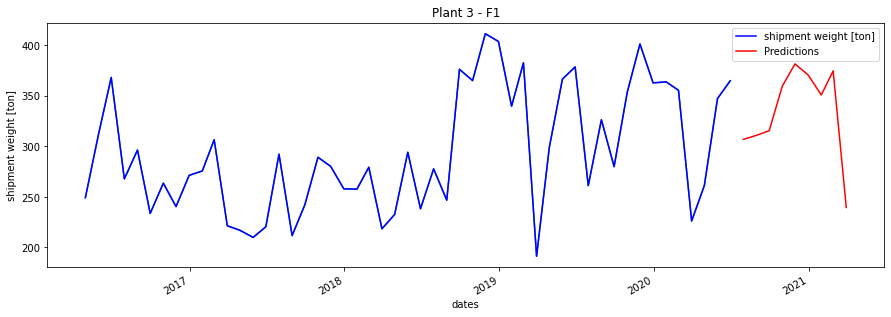

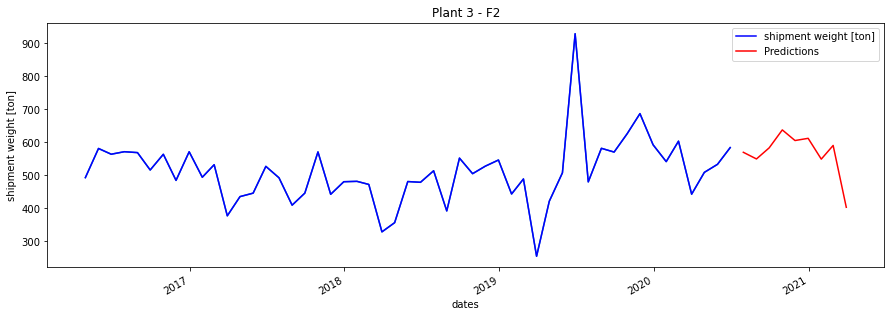

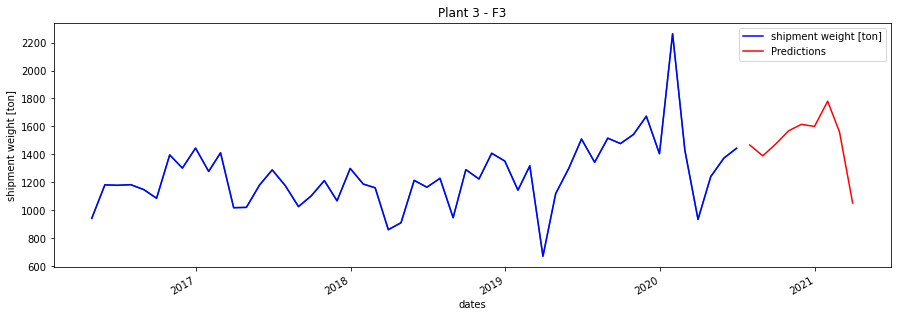

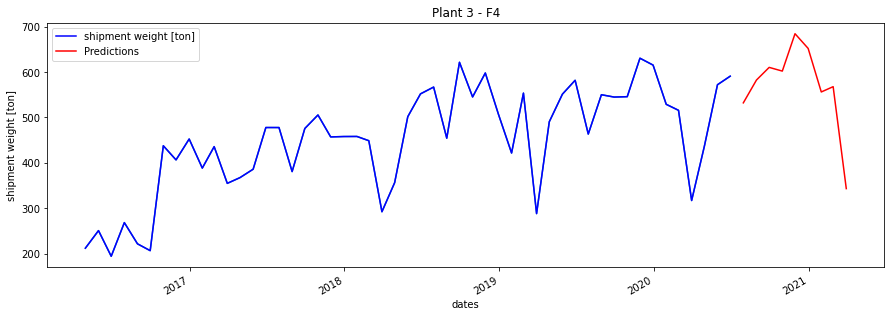

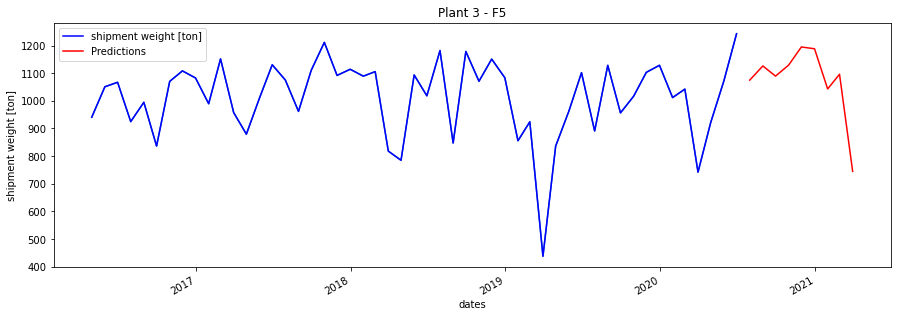

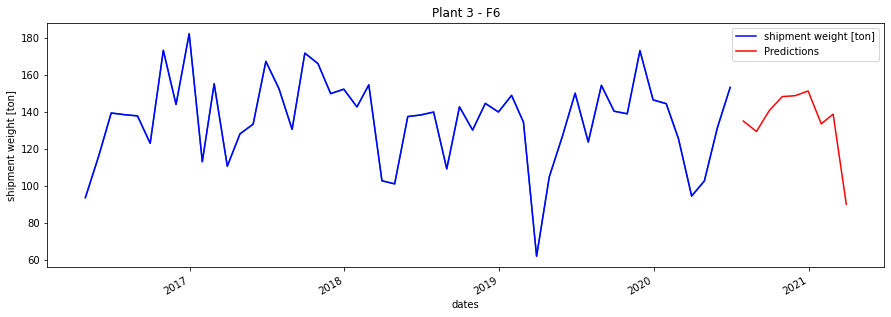

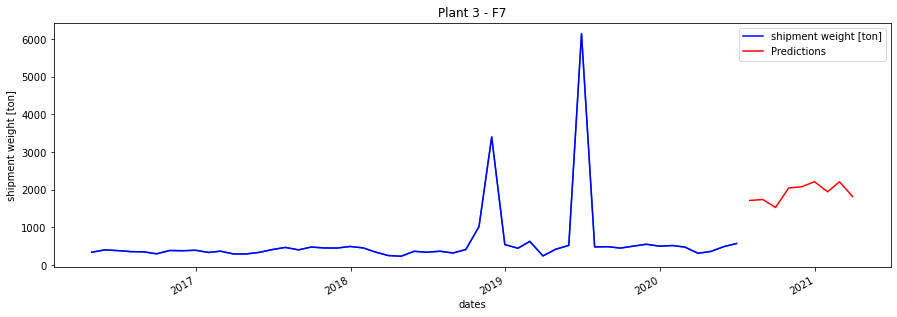

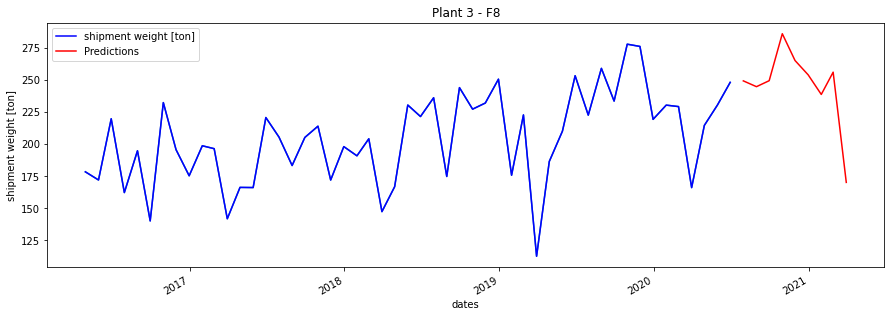

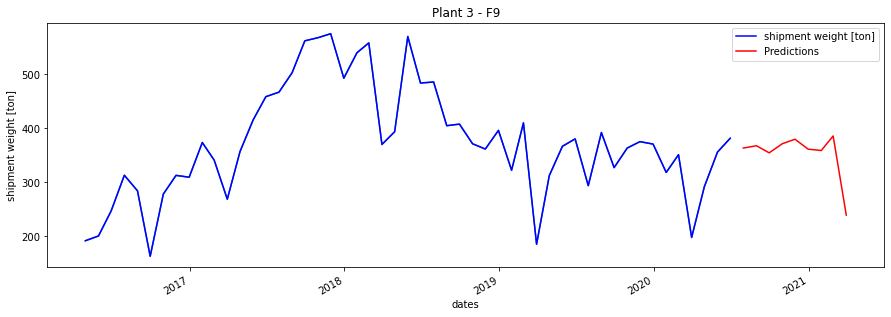

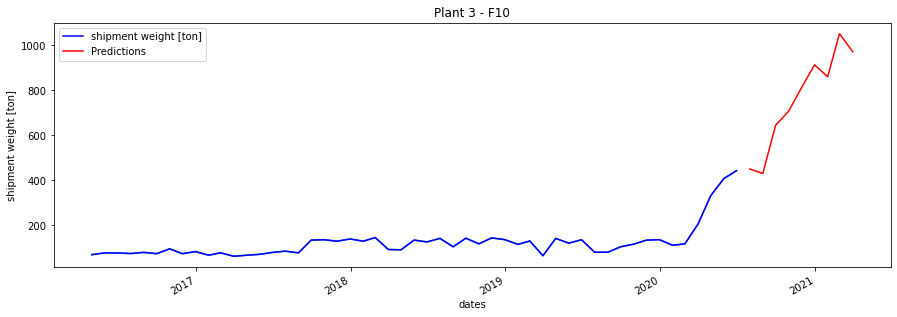

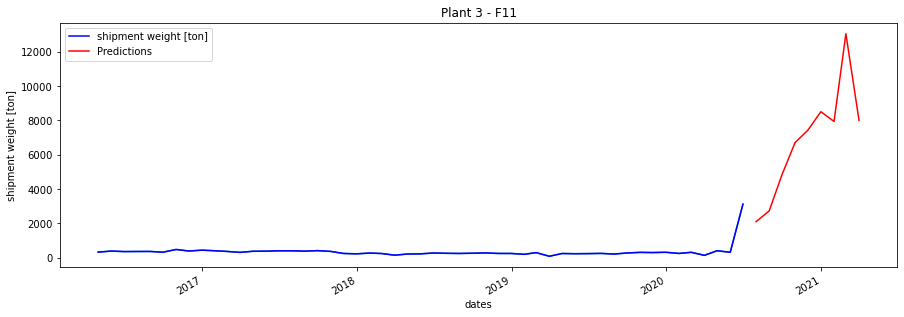

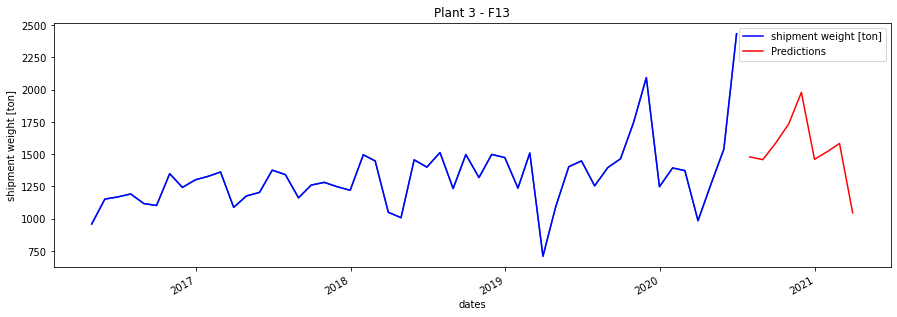

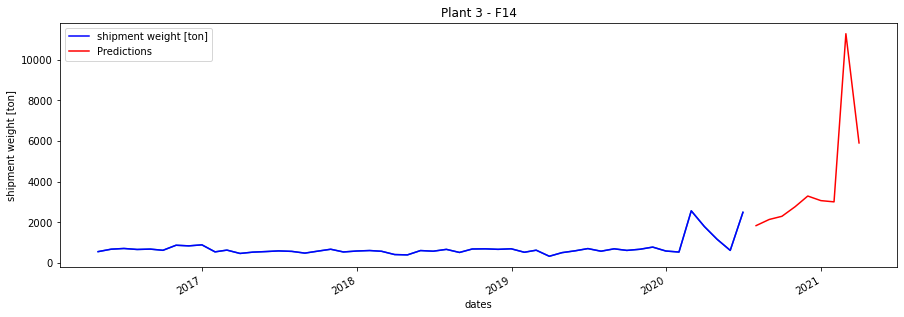

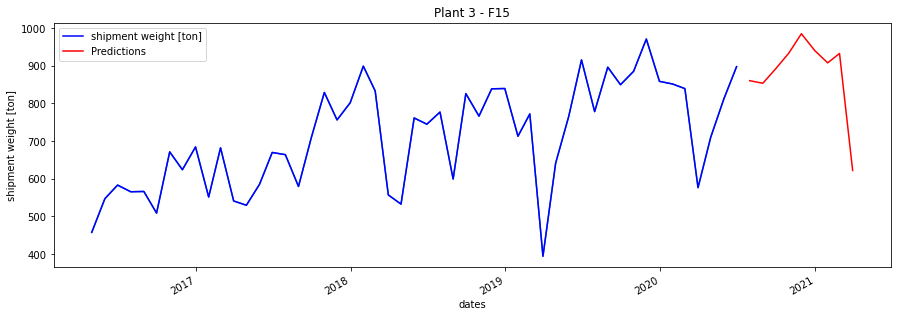

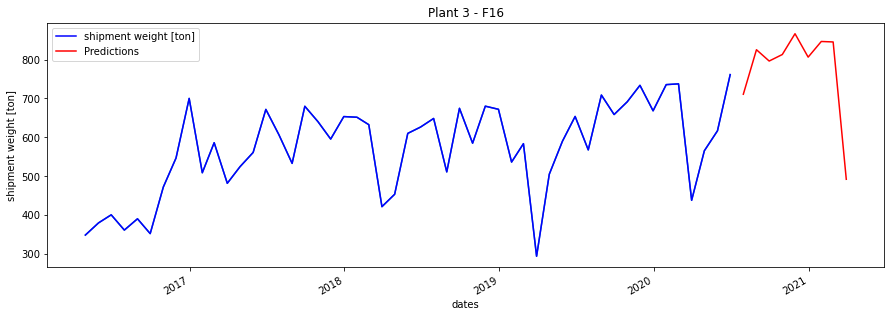

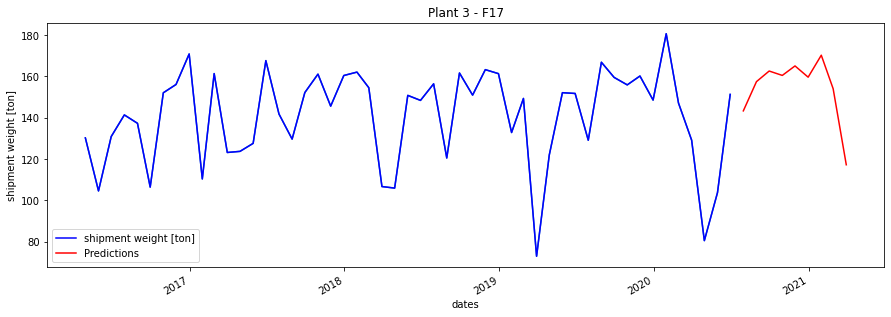

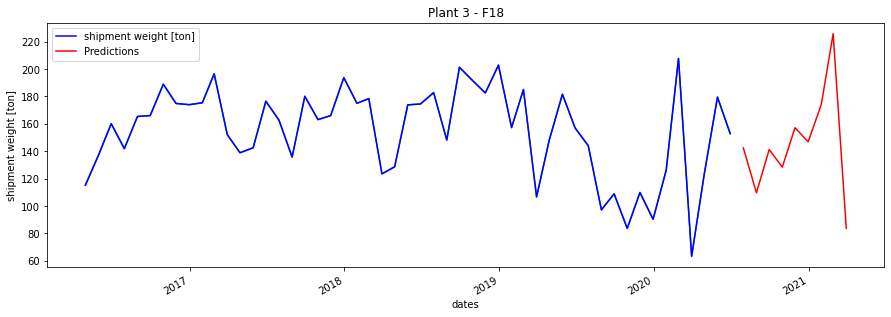

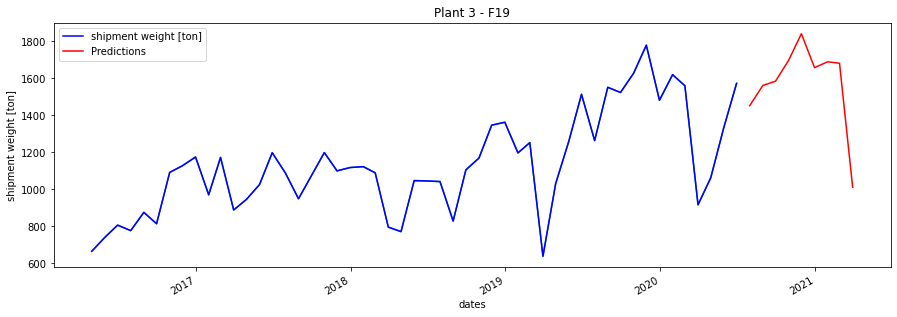

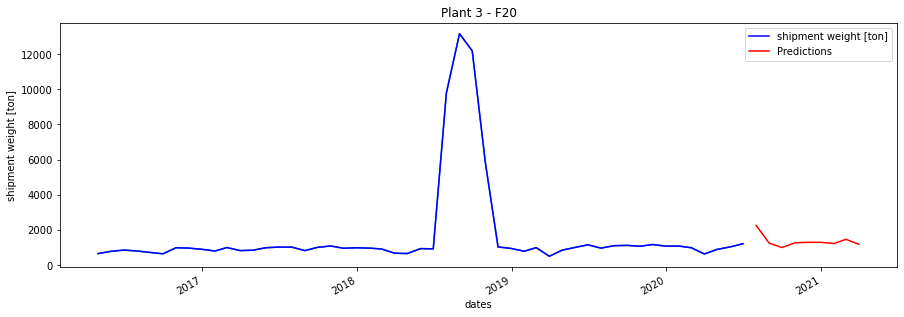

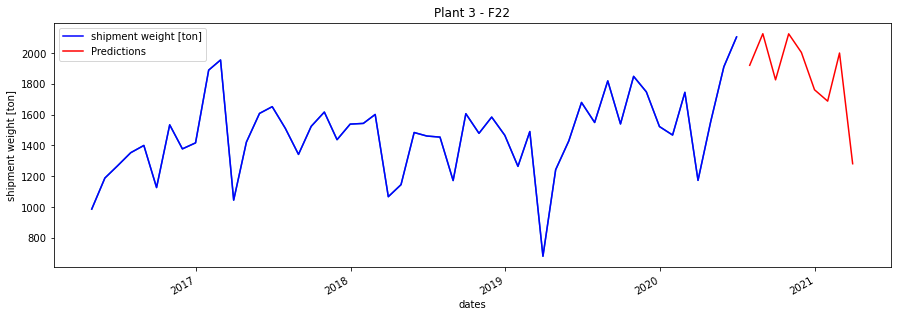

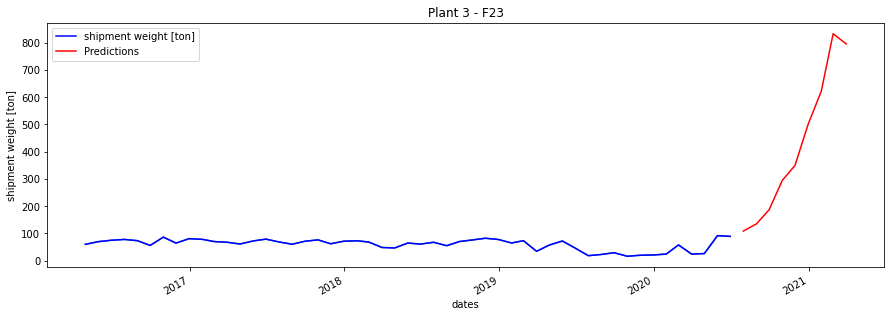

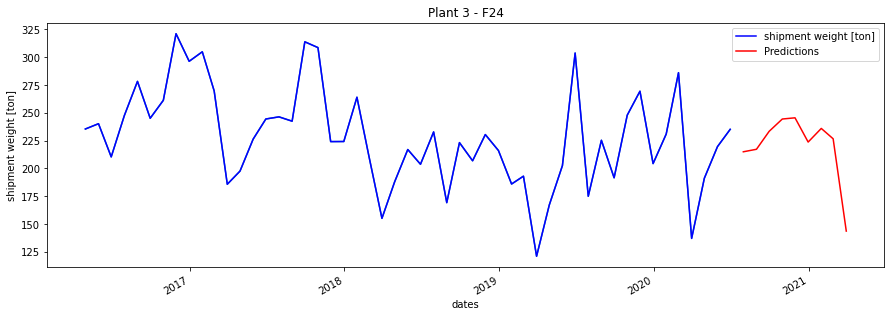

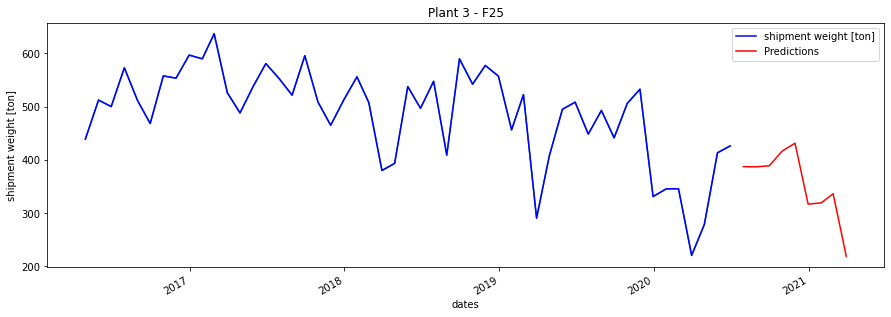

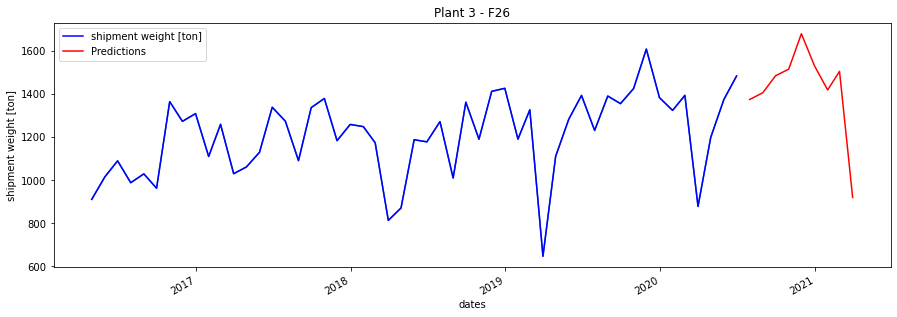

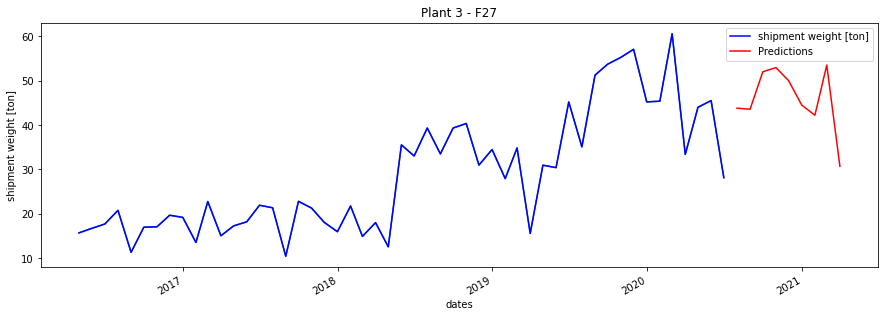

In [138]:
# iterate over each Factory
plants = ["Plant 1", "Plant 2", "Plant 3"]
for plant in plants:
    trans_df.reset_index(inplace=True)
    df = trans_df[["Factory", "Month", "Freight Forwarder", "shipment weight [ton]"]]

    df = df[df["Factory"] == plant]
    
    # iterate over each forwarder
    Forwarders = ["F"+str(x) for x in range(1, 31)]
    final_forecasts = []
    for f in Forwarders:
        err = False
        try:
            #prepare data 
            data1 = df[df["Freight Forwarder"] == f]
            data2 = data1[["Month", "shipment weight [ton]"]]
            data2.set_index("Month", inplace=True)
            data2["shipment weight [ton]"] = pd.to_numeric(data2["shipment weight [ton]"])
            data2["dates"] = pd.date_range("04, 2016", periods=51, freq="M")
            data2.set_index("dates", inplace=True)

        except ValueError:
            pass
            err = True

        if not err:
            try:
                # train model 
                final_model2 = ExponentialSmoothing(data2["shipment weight [ton]"], trend="mul", seasonal="mul", seasonal_periods=12).fit()
                forecast_predictions2 = final_model2.forecast(9)
            except:
                err = True
                pass

            if not err:
                
                # plot forecasts
                fig, ax = plt.subplots(figsize=(15,5))
                chart = sns.lineplot(x=data2.index, y='shipment weight [ton]', data = data2)
                chart.set_title(f"{plant} - {f}")
                data2.plot(ax=ax, color='blue', legend=True)

                try:
                    forecast_predictions2.plot(ax=ax, color='red', label="Predictions", legend=True)
                except:
                    pass
                
                # new variable labels
                t_fcast1 = data2
                f_fcast1 = forecast_predictions2

                # save results
                try:
                    t_fcast1 = t_fcast1.reset_index()
                    t_fcast1.columns = ['Date','TS Data']

                    f_fcast1 = f_fcast1.reset_index()
                    f_fcast1.columns = ['Date','HWES ForecastValue Future']

                    # Creating the extra columns
                    t_fcast1['HWES ForecastValue Future'] = np.nan
                    f_fcast1['TS Data'] = np.nan

                    # reordering 1 only
                    t_fcast1 = t_fcast1[['Date','HWES ForecastValue Future','TS Data']]

                    # Joining them together
                    df_fcast1 = pd.concat([t_fcast1, f_fcast1], axis=0)
                    df_fcast1['Freight Forwarder'] = f

                except:
                    df_fcast1 = pd.DataFrame({'Date': [np.nan], 'HWES ForecastValue Future': [np.nan],'TS Data': [np.nan], 'Freight Forwarder':[f]})

                # Aggregating the data to avoid duplication
                df_fcast1 = df_fcast1.groupby(['Date', 'Freight Forwarder'], as_index = False).agg({'HWES ForecastValue Future':'sum','TS Data':'sum'})

                # Saving the predictions in a DF
                try:
                    temp = pd.concat([df_fcast1], ignore_index = True)
                    final_forecasts.append(temp)
                except:
                    pass

    results = []
    for d in final_forecasts:
        forecasts = d[len(d)-9:]
        results.append(forecasts)

    delim = ";"
    writer = open("forecast_"+str(plant)+".csv", "w", encoding="UTF-8")
    
    # Write first dataframe and create file
    head = "Month;Date;Forwarder;Predictions\n"
    writer.write(head)

    rows = 0
    for i in range(0, len(results), 1):
        index = [i for i in range(1, 10)]
        date = results[i]["Date"].values
        forwarder = results[i]["Freight Forwarder"].values
        forecast = results[i]["HWES ForecastValue Future"].values
        for i in range(0, len(index), 1):
            writer.write(str(index[i])+delim)
            writer.write(str(date[i]).split("T")[0]+delim)
            writer.write(str(forwarder[i])+delim)
            writer.write(str(round(forecast[i], 2)).replace(".", ",")+"\n")
            rows += 1
    writer.flush()
    writer.close()

> The predicted values got stored for each Factory in a new csv file 